In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import os

from src.datasets.droid_dataset import DroidDataset
from configs.config import Config, DataConfig, ModelConfig, TrainConfig

In [2]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def displayImageRow(ims, axis="off", figsize=None, titles=None, cmap=None, fontsize=None):
    if not titles:
        titles = [""] * len(ims)
    fig, axes = plt.subplots(1, len(ims), figsize=figsize)
    for i in range(len(ims)):
        axes[i].set_title(titles[i], fontsize=fontsize)
        axes[i].imshow(ims[i], cmap=cmap)
        axes[i].axis(axis)
    plt.show()

def save_frames_as_gif(frames: torch.Tensor, path: str, fps: int = 15):
    # Convert to (T, H, W, C) and to numpy
    if frames.dim() == 4 and frames.shape[1] in [1, 3]:
        frames = frames.permute(0, 2, 3, 1)  # (T, H, W, C)
    frames_np = frames.cpu().numpy()

    # Convert to [0, 255] uint8
    frames_np = (frames_np * 255).clip(0, 255).astype(np.uint8)

    # Save GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imageio.mimsave(path, frames_np, fps=fps)

def normalize(arr):
    return (arr - torch.min(arr)) / (torch.max(arr) - torch.min(arr))

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTranspose = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.convTranspose(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgPool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.avgPool(x))


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, 7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.gelu(self.fc1(x)))


class Concat(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: torch.Tensor, x2: torch.Tensor):
        assert(x1.shape[1:] == x2.shape[1:]), "Concat error: tensor shape mismatch"
        return torch.cat((x1, x2), dim=1)


In [5]:
import torch
import torch.nn as nn

class WorldModelUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        action_dim: int,
        k: int,
        num_hiddens: int,
    ):
        super().__init__()
        D = num_hiddens
        self.D = D

        self.convB1 = ConvBlock(in_channels + k * 3, D)
        self.convB2 = ConvBlock(2 * D, D)

        self.downB1 = DownBlock(D, D)
        self.downB2 = DownBlock(D, 2 * D)
        self.upB1 = UpBlock(4 * D, D)
        self.upB2 = UpBlock(2 * D, D)

        self.fc1_t = FCBlock(1, 2 * D)
        self.fc2_t = FCBlock(1, D)

        self.fc1_a = FCBlock(k * action_dim, 2 * D)
        self.fc2_a = FCBlock(k * action_dim, D)

        self.final_conv = nn.Conv2d(D, 3, 3, stride=1, padding=1)

        self.concatB = Concat()

    def forward(
        self,
        x: torch.Tensor,             # (N, 3, H, W) noised frame
        frames_cond: torch.Tensor,   # (N, k, 3, H, W) past frames
        actions_cond: torch.Tensor,  # (N, k, action_dim) past actions
        t: torch.Tensor,             # (N, 1) diffusion timestep
    ) -> torch.Tensor:
        N, k, C, H, W = frames_cond.shape
        frames_flat = frames_cond.view(N, k * C, H, W)   # (N, k*3, H, W)
        actions_flat = actions_cond.view(N, -1)          # (N, k*action_dim)

        # Time and action embeddings
        cond_t1 = self.fc1_t(t).unsqueeze(-1).unsqueeze(-1)  # (N, 2D, 1, 1)
        cond_t2 = self.fc2_t(t).unsqueeze(-1).unsqueeze(-1)  # (N, D, 1, 1)

        cond_a1 = self.fc1_a(actions_flat).unsqueeze(-1).unsqueeze(-1)  # (N, 2D, 1, 1)
        cond_a2 = self.fc2_a(actions_flat).unsqueeze(-1).unsqueeze(-1)  # (N, D, 1, 1)

        # U-Net
        x_in = torch.cat([x, frames_flat], dim=1)  # (N, (1+k)*3, H, W)

        t1 = self.convB1(x_in)         # (N, D, H, W)
        t2 = self.downB1(t1)            # (N, D, H/2, W/2)
        t3 = self.downB2(t2)            # (N, 2D, H/4, W/4)

        # Apply FiLM conditioning
        t4 = t3 * cond_a1 + cond_t1     # (N, 2D, H/4, W/4)

        t5 = self.concatB(t4, t3)       # (N, 4D, H/4, W/4)

        t6 = self.upB1(t5)              # (N, D, H/2, W/2)
        t6 = t6 * cond_a2 + cond_t2

        t7 = self.concatB(t6, t2)       # (N, 2D, H/2, W/2)

        t8 = self.upB2(t7)              # (N, D, H, W)

        t9 = self.concatB(t8, t1)       # (N, 2D, H, W)

        t10 = self.convB2(t9)           # (N, D, H, W)

        return self.final_conv(t10)     # (N, 3, H, W)

In [6]:
def fm_forward(
    unet: WorldModelUNet,
    x_1: torch.Tensor,
    frames_cond: torch.Tensor,
    actions_cond: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """
    Args:
        unet: WorldModelUNet
        x_1: (N, 3, H, W) input tensor (next frame diff).
        frames_cond: (N, k, 3, H, W) past K frames.
        actions_cond: (N, k, action_dim) past K actions.
        p_uncond: probability of unconditioning the conditioning inputs.
        num_ts: number of diffusion timesteps.

    Returns:
        scalar loss
    """
    unet.train()

    N = x_1.shape[0]

    # Randomly uncondition: (N, 1)
    mask = torch.bernoulli(torch.full((N, 1), 1 - p_uncond, device=device))  # (N, 1)

    # Apply mask
    frames_cond = frames_cond * mask.view(N, 1, 1, 1, 1)  # (N, k, 3, H, W)
    actions_cond = actions_cond * mask.view(N, 1, 1)      # (N, k, action_dim)

    # Diffusion time
    t = torch.rand((x_1.shape[0], 1, 1, 1), device=device)  # (N, 1, 1, 1)

    # Corrupt input
    x_0 = torch.randn_like(x_1)
    x_t = (1 - t) * x_0 + t * x_1

    # Predict
    u_pred = unet(x_t, frames_cond, actions_cond, t.view(N, -1))        # all original shapes

    # Target velocity
    u = x_1 - x_0

    return nn.functional.mse_loss(u_pred, u), u_pred

In [7]:
@torch.inference_mode()
def fm_sample(
    unet: WorldModelUNet,
    frames_cond: torch.Tensor,   # (N, k, 3, H, W)
    actions_cond: torch.Tensor,  # (N, k, action_dim)
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    N: int = 10,
    seed: int = 0,
) -> torch.Tensor:
    """Sampling with past K frame and action conditioning."""
    unet.eval()

    torch.manual_seed(seed)
    H, W = img_wh
    step_size = 1 / num_ts

    # Prepare unconditional conditioning (zeros)
    frames_cond_zero = torch.zeros_like(frames_cond)      # (N, k, 3, H, W)
    actions_cond_zero = torch.zeros_like(actions_cond)    # (N, k, action_dim)

    # Initialize x_t (noise)
    x_t = torch.randn((N, 3, H, W), device=device)         # predict next frame difference (3 channels)

    for i in range(num_ts + 1):
        t = torch.full((N, 1), i / num_ts, device=device)  # (N, 1)

        # Predict u_cond
        u_cond_pred = unet(x_t, frames_cond, actions_cond, t)

        # Predict u_uncond (zeroed frames/actions)
        u_uncond_pred = unet(x_t, frames_cond_zero, actions_cond_zero, t)

        # Classifier-free guidance
        u_pred = u_uncond_pred + guidance_scale * (u_cond_pred - u_uncond_pred)

        # Update x_t
        x_t += step_size * u_pred

    return x_t

In [8]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: WorldModelUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(
        self,
        x: torch.Tensor,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, 3, H, W) target next frame difference.
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.

        Returns:
            scalar loss.
        """
        return fm_forward(
            self.unet, x, frames_cond, actions_cond, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        N: int = 10,
        seed: int = 0,
    ) -> torch.Tensor:
        """
        Args:
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.
            img_wh: (H, W) image size.
            guidance_scale: float, classifier-free guidance scale.
            N: batch size.
            seed: int, random seed.

        Returns:
            (N, 3, H, W) predicted frame difference samples.
        """
        return fm_sample(
            self.unet, frames_cond, actions_cond, img_wh, self.num_ts, guidance_scale, N, seed
        )

## Train 3: Predict Difference with Cascaded Models

In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2025-05-11 20:46:56.775369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 20:46:56.788019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747021616.802248 3810188 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747021616.806821 3810188 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747021616.818615 3810188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1747021619.819616 3810188 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140746 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:c3:00.0, compute capability: 9.0


In [10]:
cfg = Config()

31212


100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 1, Avg Training Loss: 0.130567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8967406..2.2390833].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4958053..2.5897636].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9346697..2.0625615].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7221539..1.6070879].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7862239..1.7103525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5785419..1.3123051].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.473181

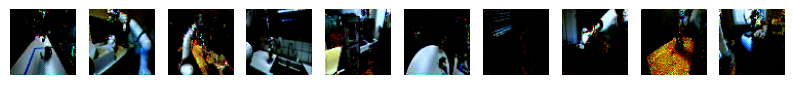

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

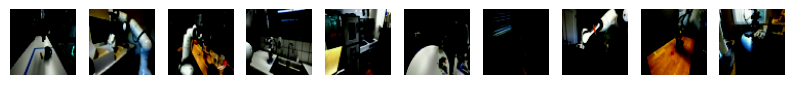

100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


Epoch 2, Avg Training Loss: 0.057766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9183378..2.3208022].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.083967..2.4025767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2056478..1.2263998].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6430643..1.601789].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5100145..1.622489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3201033..1.1076193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2148749..

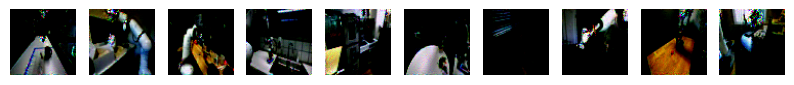

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

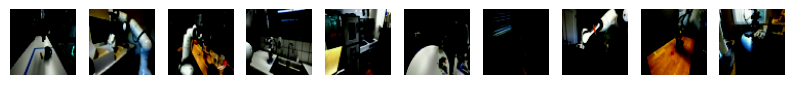

100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 3, Avg Training Loss: 0.047610


100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 4, Avg Training Loss: 0.043207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7424273..1.9655819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9445974..2.2531672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1571519..1.1933988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3861829..1.3067266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3738359..1.2287704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1205046..1.0584328].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.126735

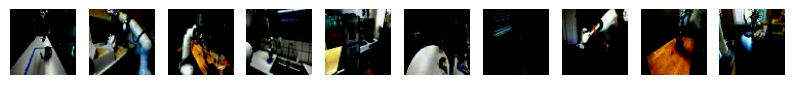

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

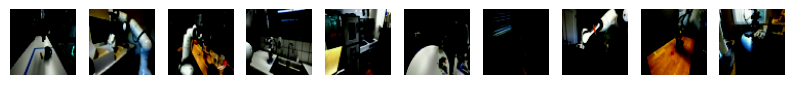

100%|██████████| 391/391 [00:32<00:00, 12.01it/s]


Epoch 5, Avg Training Loss: 0.040048


100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


Epoch 6, Avg Training Loss: 0.037022


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


Epoch 7, Avg Training Loss: 0.034743


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.513464..1.2456148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7764175..1.8524907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1394689..1.1588739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.18858..1.1576355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1405987..1.1156738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0686886..1.086226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0828494..0

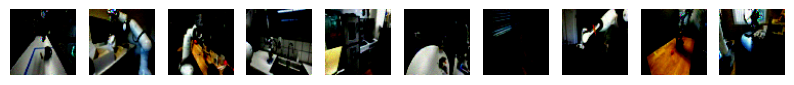

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

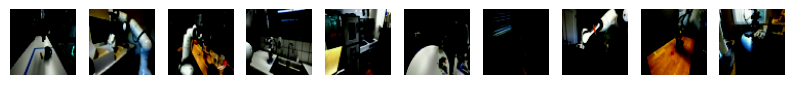

100%|██████████| 391/391 [00:31<00:00, 12.26it/s]


Epoch 8, Avg Training Loss: 0.033430


100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 9, Avg Training Loss: 0.032933


100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 10, Avg Training Loss: 0.030929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4958911..1.0315504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.698407..1.7164248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.080009..1.1460681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0522746..1.1075069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.227936..1.0574291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0371015..1.0132592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0542737..

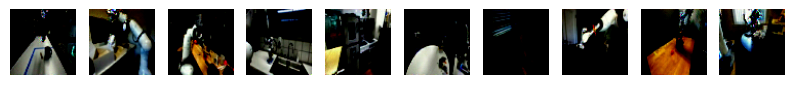

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

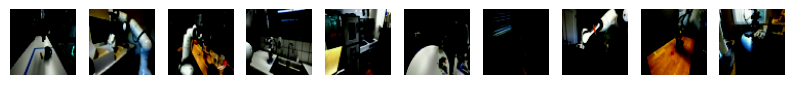

100%|██████████| 391/391 [00:31<00:00, 12.51it/s]


Epoch 11, Avg Training Loss: 0.031114


100%|██████████| 391/391 [00:31<00:00, 12.49it/s]


Epoch 12, Avg Training Loss: 0.029422


100%|██████████| 391/391 [00:29<00:00, 13.11it/s]


Epoch 13, Avg Training Loss: 0.027342


100%|██████████| 391/391 [00:29<00:00, 13.10it/s]


Epoch 14, Avg Training Loss: 0.025657


100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Epoch 15, Avg Training Loss: 0.025811


100%|██████████| 391/391 [00:30<00:00, 13.01it/s]


Epoch 16, Avg Training Loss: 0.025961


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch 17, Avg Training Loss: 0.024276


100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Epoch 18, Avg Training Loss: 0.022608


100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


Epoch 19, Avg Training Loss: 0.022891


100%|██████████| 391/391 [00:30<00:00, 12.97it/s]


Epoch 20, Avg Training Loss: 0.022779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2406819..0.93549293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2637689..1.1773732].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0279925..1.038692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.03887..1.0960512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0632048..1.0371281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0105245..1.007108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0521979..

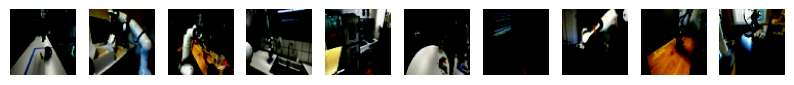

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

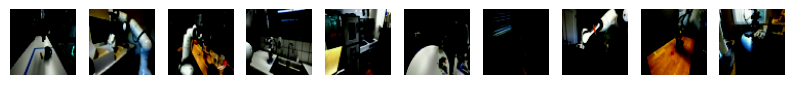

100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


Epoch 21, Avg Training Loss: 0.022486


100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch 22, Avg Training Loss: 0.022286


100%|██████████| 391/391 [00:29<00:00, 13.03it/s]


Epoch 23, Avg Training Loss: 0.022072


100%|██████████| 391/391 [00:29<00:00, 13.09it/s]


Epoch 24, Avg Training Loss: 0.020444


100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Epoch 25, Avg Training Loss: 0.022212


100%|██████████| 391/391 [00:29<00:00, 13.08it/s]


Epoch 26, Avg Training Loss: 0.021376


100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Epoch 27, Avg Training Loss: 0.020874


100%|██████████| 391/391 [00:29<00:00, 13.11it/s]


Epoch 28, Avg Training Loss: 0.019932


100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


Epoch 29, Avg Training Loss: 0.020332


100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Epoch 30, Avg Training Loss: 0.020114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2151005..0.93786407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2201897..1.1216477].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.025052..1.0383391].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0611198..1.0928074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0631053..1.1285243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0179057..0.98139614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.03597

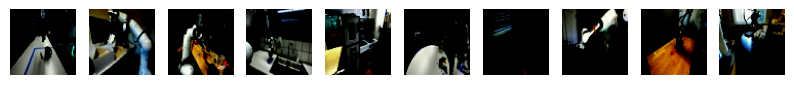

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

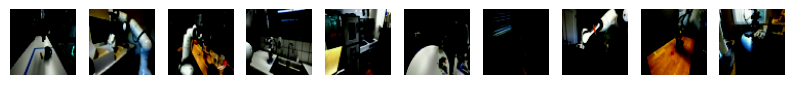

100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Epoch 31, Avg Training Loss: 0.020182


100%|██████████| 391/391 [00:29<00:00, 13.31it/s]


Epoch 32, Avg Training Loss: 0.019773


100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


Epoch 33, Avg Training Loss: 0.019662


100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch 34, Avg Training Loss: 0.018427


100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Epoch 35, Avg Training Loss: 0.019175


100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Epoch 36, Avg Training Loss: 0.019663


100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Epoch 37, Avg Training Loss: 0.018895


100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Epoch 38, Avg Training Loss: 0.018116


100%|██████████| 391/391 [00:29<00:00, 13.15it/s]


Epoch 39, Avg Training Loss: 0.018614


100%|██████████| 391/391 [00:29<00:00, 13.15it/s]


Epoch 40, Avg Training Loss: 0.018031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1293333..0.94630635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1786056..1.0594071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0085438..1.020249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0311326..1.0667722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2074332..1.4818263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99503654..0.9945735].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.01800

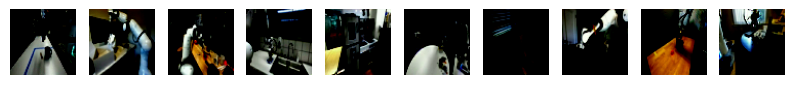

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

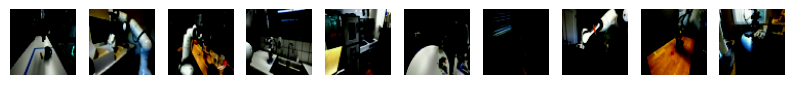

100%|██████████| 391/391 [00:29<00:00, 13.13it/s]


Epoch 41, Avg Training Loss: 0.018350


100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Epoch 42, Avg Training Loss: 0.018166


100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


Epoch 43, Avg Training Loss: 0.017970


100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Epoch 44, Avg Training Loss: 0.016791


100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


Epoch 45, Avg Training Loss: 0.027306


100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch 46, Avg Training Loss: 0.020712


100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch 47, Avg Training Loss: 0.025501


100%|██████████| 391/391 [00:29<00:00, 13.18it/s]


Epoch 48, Avg Training Loss: 0.019721


100%|██████████| 391/391 [00:29<00:00, 13.15it/s]


Epoch 49, Avg Training Loss: 0.018984


100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Epoch 50, Avg Training Loss: 0.018240


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1809633..0.9464982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1494025..1.0467207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0233579..1.017056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0175127..1.0928135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1745727..1.3127546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.00424..0.98066384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0239786.

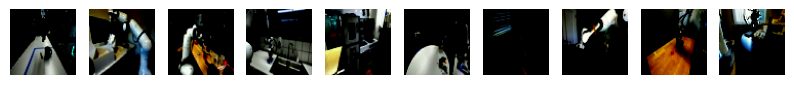

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

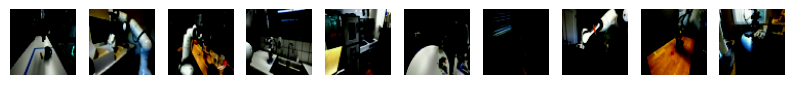

In [11]:
device = "cuda"

# Hyperparameters
D = 256
learning_rate = 1e-4
num_epochs = 50
test_epochs = [1, 2, 4, 7, 10, 20, 30, 40, 50]
batch_size = 64
K = 10
N = 1   # number of cascaded models
sample_rate = 0   # probability of sampling gt

# Load dataset and split
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=K+N,
    img_size=(64, 64),
)
# dataset = DroidDataset(k=K+N, frame_size=(64, 64), dir="drive/MyDrive/CS280/droid_small", video_source="observation.images.exterior_1_left")
print(len(dataset))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define model
models = [
    FlowMatching(WorldModelUNet(
        in_channels=3,
        action_dim=7,
        k=K,
        num_hiddens=D,
    )).to(device)
    for _ in range(N)
]

# Optimizer and scheduler
optimizers = [
    torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    for model in models
]
schedulers = [
    torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
    for opt in optimizers
]

training_losses = []
avg_train_losses = []
test_data = []

try:
    for epoch in range(num_epochs):
        for model in models:
            model.train()
        avg_train_loss = 0

        for sample_dict in tqdm(trainloader):
        #for frames_cond, actions_cond, _, _ in tqdm(trainloader):
            frames_cond = sample_dict["context_obs"]
            actions_cond = sample_dict["context_acts"]
            # print(frames_cond.shape, actions_cond.shape)
            frames_cond = frames_cond.to(device)     # (B, k, 3, H, W)
            actions_cond = actions_cond.to(device)   # (B, k, action_dim)

            for opt in optimizers:
                opt.zero_grad()
            # loss = 0
            B = frames_cond.size(0)
            pred_frames = frames_cond[:, :K].clone()

            for i, model in enumerate(models):
                frames_cond_i = frames_cond[:, i:i+K]   # (B, k, 3, H, W)
                frames_cond_pred_i = pred_frames        # (B, k, 3, H, W)
                # print(frames_cond_i.shape, frames_cond_pred_i.shape)
                mask = (torch.rand(B, K, 1, 1, 1, device=device) < sample_rate).float()
                frames_cond_mix_i = mask * frames_cond_i + (1 - mask) * frames_cond_pred_i

                actions_cond_i = actions_cond[:, i:i+K]

                frame_cur_i = frames_cond_mix_i[:, -1]
                frame_next_i = frames_cond[:, i+K]
                label_i = frame_next_i - frame_cur_i

                # print(frames_cond_mix_i.shape, actions_cond_i.shape, label_i.shape)
                loss_i, pred_i = model(label_i, frames_cond_mix_i, actions_cond_i)

                pred_next_frame = frame_cur_i + pred_i.detach()
                pred_frames = torch.cat([pred_frames[:, 1:], pred_next_frame.unsqueeze(1)], dim=1)

                loss_i.backward()
                optimizers[i].step()

            for scheduler in schedulers:
                scheduler.step()

            avg_train_loss += loss_i.item() / len(trainloader)
            
            training_losses.append(loss_i.item())
            avg_train_losses.append(avg_train_loss)
        # scheduler.step()
        print(f"Epoch {epoch + 1}, Avg Training Loss: {avg_train_loss:.6f}")

        # testing (sampling)
        if (epoch + 1) in test_epochs:
            for model in models:
                model.eval()
            batch = next(iter(testloader))
            frames_cond = batch["context_obs"]
            actions_cond = batch["context_acts"]
            ground_truth = batch["obs"]
            # frames_cond, actions_cond, _, ground_truth = batch

            frames_cond = frames_cond.to(device)
            actions_cond = actions_cond.to(device)

            # Only take the most recent frame (the latest in frames_cond sequence)
            current_frame = frames_cond[:, -1]  # (N, 3, H, W)

            # Sample the predicted difference
            # predicted_diff = models[-1].sample(
            #     frames_cond[:10],
            #     actions_cond[:10],
            #     img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
            #     guidance_scale=5.0,
            #     N=10,  # should match frames_cond[:10]
            # ).cpu()
            
            predicted_diff = models[-1].sample(
                frames_cond[:10, :K],
                actions_cond[:10, :K],
                img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
                guidance_scale=5.0,
                N=10,  # should match frames_cond[:10]
            ).cpu()
            # Compute predicted next frames
            predicted_next_frame = current_frame[:10].cpu() + predicted_diff  # add predicted delta

            # Display first few predicted next frames
            displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
            displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

            # test_data.append(predicted_next_frame.numpy())

finally:
    pass
#     dataset.close()

In [13]:
avg_train_losses = [
    0.130567, 0.057766, 0.047610, 0.043207, 0.040048, 0.037022, 0.034743, 0.033430, 0.032933, 0.030929,
    0.031114, 0.029422, 0.027342, 0.025657, 0.025811, 0.025961, 0.024276, 0.022608, 0.022891, 0.022779,
    0.022486, 0.022286, 0.022072, 0.020444, 0.022212, 0.021376, 0.020874, 0.019932, 0.020332, 0.020114,
    0.020182, 0.019773, 0.019662, 0.018427, 0.019175, 0.019663, 0.018895, 0.018116, 0.018614, 0.018031,
    0.018350, 0.018166, 0.017970, 0.016791, 0.027306, 0.020712, 0.025501, 0.019721, 0.018984, 0.018240
]

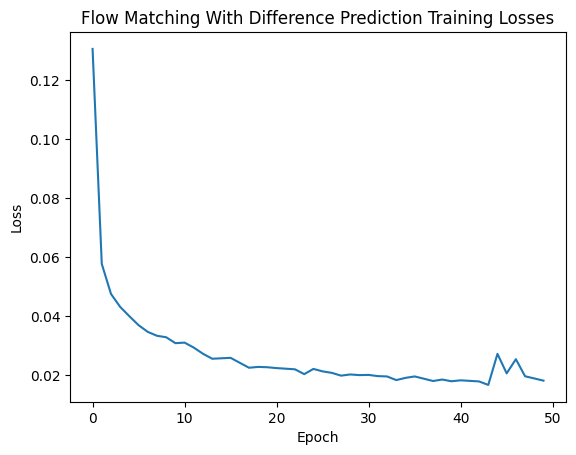

In [20]:
plt.title("Flow Matching With Difference Prediction Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(avg_train_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1809633..0.9464982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1494025..1.0467207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0233579..1.017056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0175127..1.0928135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1745727..1.3127546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.00424..0.98066384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0239786.

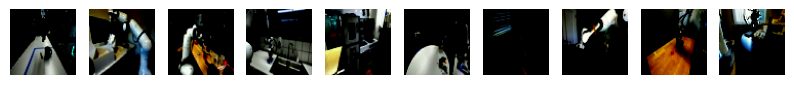

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6627451].
Clipping input data to

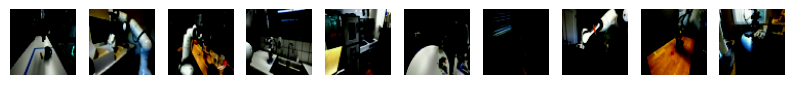

In [16]:
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=K+N,
    img_size=(64, 64),
)
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

try:

    for model in models:
        model.eval()
    batch = next(iter(testloader))
    # frames_cond, actions_cond, _, ground_truth = batch
    frames_cond = batch["context_obs"]
    actions_cond = batch["context_acts"]
    ground_truth = batch["obs"]
    frames_cond = frames_cond.to(device)
    actions_cond = actions_cond.to(device)

    # Only take the most recent frame (the latest in frames_cond sequence)
    current_frame = frames_cond[:, K]  # (N, 3, H, W)

    # Sample the predicted difference
    predicted_diff = models[-1].sample(
        frames_cond[:10, :K],
        actions_cond[:10, :K],
        img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
        guidance_scale=5.0,
        N=10,  # should match frames_cond[:10]
    ).cpu()

    # Compute predicted next frames
    predicted_next_frame = current_frame[:10, :K].cpu() + predicted_diff  # add predicted delta

    # Display first few predicted next frames
    displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
    displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

finally:
    pass

In [17]:
filename = 'output_flow_matching_difference_actual/'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to th

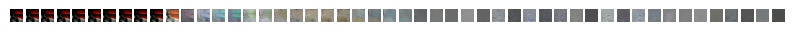

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to t

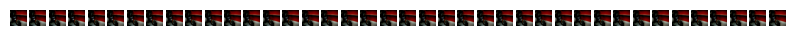

In [18]:
test_dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=50,
    img_size=(64, 64),
)

try:
    batch = test_dataset[150]
    frames = batch["context_obs"]
    actions = batch["context_acts"]

    # frames, actions, _, _ = test_dataset[150]
    frames_cond = frames[:K]
    # frames_cond = frames

    pred_frames = frames_cond.clone().to(device)
    actions = actions.to(device)
    
    # print(pred_frames.shape, actions.shape)
    for i in range(K, 50):
        pred_diff = models[-1].sample(
            pred_frames[-K:].unsqueeze(0),
            actions[i-K:i].unsqueeze(0),                           # Corresponding K actions
            img_wh=(frames.shape[-2], frames.shape[-1]),
            guidance_scale=5.0,
            N=1,
        )
        #     actions[i-K:i].unsqueeze(0),                 # corresponding K actions
        #     img_wh=(frames.shape[-2], frames.shape[-1]),
        #     guidance_scale=5.0,
        #     N=1,
        # )
        # print(pred_diff.shape)
        # print(pred_frames[-1].shape)
        pred = pred_frames[-1] + pred_diff
        pred = normalize(pred)
        # print(pred.shape)
        # print(pred_frames.shape)
        pred_frames = torch.cat([pred_frames, pred], dim=0)  # append prediction

finally:
    pass
    # test_dataset.close()

displayImageRow(pred_frames.cpu().permute(0, 2, 3, 1), figsize=(10,10))
displayImageRow(frames[K:].permute(0, 2, 3, 1), figsize=(10,10))
save_frames_as_gif(pred_frames, filename+"predicted_1.gif")
save_frames_as_gif(frames, filename+"ground_truth_1.gif")


{'obs': tensor([[[ 0.6784,  0.6863,  0.4353,  ..., -0.7804, -0.7020, -0.5216],
         [ 0.6863,  0.6863,  0.5686,  ..., -0.8039, -0.6314, -0.6000],
         [ 0.6784,  0.6784,  0.6471,  ..., -0.5843, -0.4353, -0.4275],
         ...,
         [-0.7725, -0.2549, -0.0353,  ...,  0.6392,  0.6392,  0.6235],
         [-0.4039, -0.0667,  0.0118,  ...,  0.6235,  0.6157,  0.5922],
         [-0.1765, -0.0196, -0.0510,  ...,  0.6000,  0.5922,  0.5608]],

        [[ 0.8275,  0.8588,  0.5608,  ..., -0.7647, -0.7020, -0.5137],
         [ 0.8275,  0.8510,  0.7020,  ..., -0.7804, -0.6078, -0.5686],
         [ 0.8196,  0.8353,  0.7882,  ..., -0.5608, -0.4039, -0.3961],
         ...,
         [-0.6863, -0.1216,  0.1373,  ...,  0.5765,  0.5765,  0.5686],
         [-0.2784,  0.0980,  0.1765,  ...,  0.5686,  0.5686,  0.5529],
         [-0.0196,  0.1373,  0.1137,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9451,  0.9373,  0.6235,  ..., -0.6706, -0.5922, -0.4353],
         [ 0.9451,  0.9451,  0.7725, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

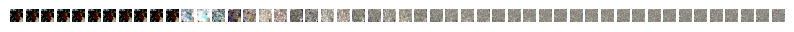

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

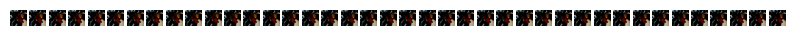

{'obs': tensor([[[ 0.6863,  0.7020,  0.4510,  ..., -0.7725, -0.7333, -0.5059],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.7961, -0.6549, -0.5686],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5686, -0.4431, -0.4118],
         ...,
         [-0.7647, -0.2627, -0.0588,  ...,  0.6314,  0.6314,  0.6157],
         [-0.3961, -0.0824, -0.0039,  ...,  0.6078,  0.6078,  0.6078],
         [-0.1765, -0.0353, -0.0667,  ...,  0.5843,  0.5843,  0.5765]],

        [[ 0.8275,  0.8588,  0.5843,  ..., -0.7569, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7804, -0.6235, -0.5451],
         [ 0.8196,  0.8353,  0.8039,  ..., -0.5686, -0.4118, -0.3961],
         ...,
         [-0.6863, -0.1216,  0.1137,  ...,  0.5843,  0.5843,  0.5608],
         [-0.2784,  0.0902,  0.1529,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0353,  0.1294,  0.0824,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9451,  0.9451,  0.6471,  ..., -0.6706, -0.6314, -0.4275],
         [ 0.9373,  0.9451,  0.7882, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

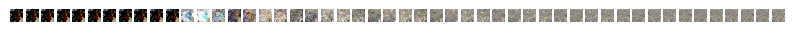

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

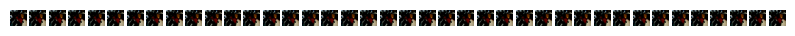

{'obs': tensor([[[ 0.6706,  0.7020,  0.4431,  ..., -0.7725, -0.7176, -0.5137],
         [ 0.6784,  0.6941,  0.5686,  ..., -0.7961, -0.6314, -0.5843],
         [ 0.6706,  0.6863,  0.6549,  ..., -0.5765, -0.4275, -0.4275],
         ...,
         [-0.7725, -0.2549, -0.0431,  ...,  0.6314,  0.6314,  0.6157],
         [-0.4039, -0.0588,  0.0118,  ...,  0.6157,  0.6000,  0.5922],
         [-0.1765, -0.0196, -0.0510,  ...,  0.5922,  0.5765,  0.5608]],

        [[ 0.8353,  0.8588,  0.5686,  ..., -0.7647, -0.6941, -0.5059],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6000, -0.5608],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5608, -0.4039, -0.4039],
         ...,
         [-0.6863, -0.1216,  0.1137,  ...,  0.5843,  0.5843,  0.5765],
         [-0.2706,  0.0980,  0.1686,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0275,  0.1529,  0.1059,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9294,  0.9294,  0.6314,  ..., -0.6706, -0.6078, -0.4275],
         [ 0.9373,  0.9294,  0.7725, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

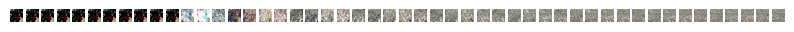

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

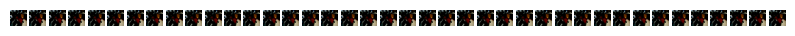

{'obs': tensor([[[ 0.6863,  0.6941,  0.4510,  ..., -0.7725, -0.7176, -0.5059],
         [ 0.6784,  0.6863,  0.5843,  ..., -0.7961, -0.6392, -0.5765],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5686, -0.4196, -0.4118],
         ...,
         [-0.7804, -0.2784, -0.0667,  ...,  0.6157,  0.6235,  0.6157],
         [-0.4118, -0.0667, -0.0118,  ...,  0.6078,  0.6078,  0.5922],
         [-0.1765, -0.0196, -0.0745,  ...,  0.5922,  0.5843,  0.5608]],

        [[ 0.8275,  0.8510,  0.5765,  ..., -0.7647, -0.7098, -0.4980],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6078, -0.5451],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.6941, -0.1451,  0.0980,  ...,  0.5843,  0.5765,  0.5686],
         [-0.2941,  0.0824,  0.1451,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0353,  0.1451,  0.0824,  ...,  0.5765,  0.5608,  0.5451]],

        [[ 0.9373,  0.9373,  0.6392,  ..., -0.6784, -0.6235, -0.4196],
         [ 0.9373,  0.9373,  0.7804, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

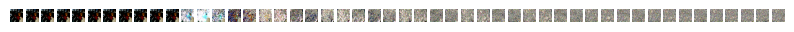

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

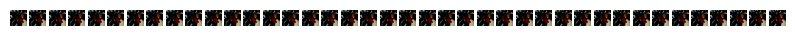

{'obs': tensor([[[ 0.6863,  0.7020,  0.4510,  ..., -0.7725, -0.7098, -0.5059],
         [ 0.6863,  0.6941,  0.5843,  ..., -0.7961, -0.6392, -0.5765],
         [ 0.6863,  0.6863,  0.6549,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7804, -0.2863, -0.0745,  ...,  0.6157,  0.6235,  0.6157],
         [-0.4275, -0.0902, -0.0275,  ...,  0.6000,  0.6078,  0.6000],
         [-0.1843, -0.0510, -0.0902,  ...,  0.6078,  0.6000,  0.5608]],

        [[ 0.8353,  0.8431,  0.5686,  ..., -0.7569, -0.7098, -0.5059],
         [ 0.8353,  0.8431,  0.7098,  ..., -0.7725, -0.6157, -0.5529],
         [ 0.8275,  0.8353,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.6941, -0.1765,  0.0745,  ...,  0.5922,  0.5843,  0.5686],
         [-0.3255,  0.0431,  0.1294,  ...,  0.5843,  0.5686,  0.5608],
         [-0.0588,  0.1059,  0.0667,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9451,  0.9529,  0.6471,  ..., -0.6784, -0.6157, -0.4275],
         [ 0.9451,  0.9529,  0.7961, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

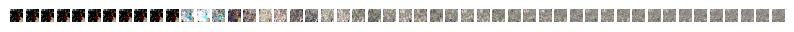

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

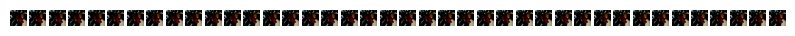

{'obs': tensor([[[ 0.6863,  0.7020,  0.4431,  ..., -0.7882, -0.7255, -0.5059],
         [ 0.6863,  0.6941,  0.5765,  ..., -0.8039, -0.6471, -0.5765],
         [ 0.6784,  0.6863,  0.6627,  ..., -0.5686, -0.4353, -0.4196],
         ...,
         [-0.7804, -0.2941, -0.0824,  ...,  0.6392,  0.6392,  0.6235],
         [-0.4275, -0.1059, -0.0431,  ...,  0.6235,  0.6235,  0.6078],
         [-0.1922, -0.0510, -0.0902,  ...,  0.6000,  0.5922,  0.5765]],

        [[ 0.8196,  0.8510,  0.5843,  ..., -0.7725, -0.7098, -0.4980],
         [ 0.8275,  0.8431,  0.7176,  ..., -0.7725, -0.6157, -0.5451],
         [ 0.8275,  0.8353,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.7020, -0.1922,  0.0588,  ...,  0.5765,  0.5765,  0.5608],
         [-0.3255,  0.0353,  0.1137,  ...,  0.5686,  0.5608,  0.5529],
         [-0.0588,  0.0902,  0.0510,  ...,  0.5686,  0.5529,  0.5294]],

        [[ 0.9451,  0.9529,  0.6549,  ..., -0.6706, -0.6157, -0.4118],
         [ 0.9373,  0.9451,  0.7961, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

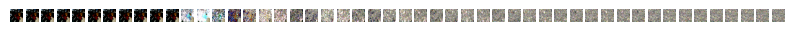

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

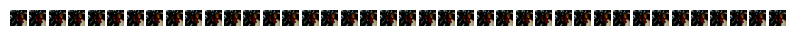

{'obs': tensor([[[ 0.1059,  0.3647,  0.2078,  ..., -0.1686, -0.1765, -0.1765],
         [ 0.2784,  0.3098, -0.0588,  ..., -0.1137, -0.1294, -0.1373],
         [ 0.3333,  0.1059, -0.6000,  ..., -0.0824, -0.0902, -0.0980],
         ...,
         [-0.8039, -0.5922, -0.7098,  ...,  0.2706,  0.2549,  0.2392],
         [-0.5373, -0.4824, -0.7176,  ...,  0.2706,  0.2471,  0.2235],
         [-0.2863, -0.4510, -0.7333,  ...,  0.2706,  0.2471,  0.2157]],

        [[ 0.2235,  0.4588,  0.3098,  ..., -0.7020, -0.6941, -0.6941],
         [ 0.4039,  0.4275,  0.0275,  ..., -0.6706, -0.6706, -0.6784],
         [ 0.4667,  0.2235, -0.5294,  ..., -0.6471, -0.6392, -0.6471],
         ...,
         [-0.8196, -0.5922, -0.7490,  ...,  0.2627,  0.2549,  0.2471],
         [-0.5451, -0.4824, -0.7490,  ...,  0.2392,  0.2392,  0.2314],
         [-0.2863, -0.4431, -0.7569,  ...,  0.2314,  0.2314,  0.2235]],

        [[ 0.2549,  0.4980,  0.3176,  ..., -0.9216, -0.9137, -0.8980],
         [ 0.4431,  0.4588,  0.0275, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to 

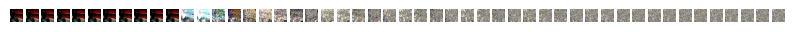

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the 

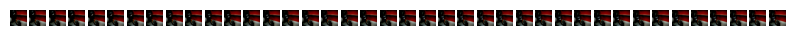

{'obs': tensor([[[ 0.2000,  0.4196,  0.3098,  ..., -0.1686, -0.1765, -0.1765],
         [ 0.1529,  0.1529,  0.3333,  ..., -0.1373, -0.1451, -0.1529],
         [ 0.4118,  0.1451,  0.3412,  ..., -0.0902, -0.0980, -0.1059],
         ...,
         [-0.8196, -0.5922, -0.7176,  ...,  0.2706,  0.2549,  0.2392],
         [-0.5451, -0.4824, -0.7255,  ...,  0.2627,  0.2471,  0.2314],
         [-0.2863, -0.4588, -0.7412,  ...,  0.2549,  0.2392,  0.2314]],

        [[ 0.2941,  0.5216,  0.4118,  ..., -0.7020, -0.7020, -0.6941],
         [ 0.2549,  0.2627,  0.4353,  ..., -0.6706, -0.6706, -0.6706],
         [ 0.5294,  0.2627,  0.4510,  ..., -0.6392, -0.6392, -0.6392],
         ...,
         [-0.8118, -0.5922, -0.7490,  ...,  0.2784,  0.2627,  0.2471],
         [-0.5373, -0.4745, -0.7490,  ...,  0.2627,  0.2471,  0.2392],
         [-0.2784, -0.4431, -0.7569,  ...,  0.2471,  0.2314,  0.2235]],

        [[ 0.3255,  0.5451,  0.4275,  ..., -0.9294, -0.9059, -0.8824],
         [ 0.2863,  0.3020,  0.4745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to 

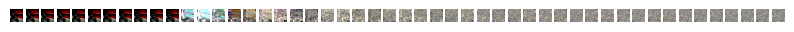

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to th

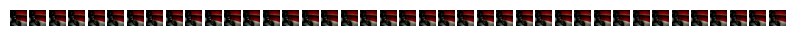

{'obs': tensor([[[ 0.3333,  0.2863, -0.2471,  ..., -0.1608, -0.1765, -0.1843],
         [ 0.2706, -0.0275, -0.6706,  ..., -0.1294, -0.1373, -0.1529],
         [ 0.0980, -0.5686, -0.9059,  ..., -0.0902, -0.0902, -0.1059],
         ...,
         [-0.8196, -0.5922, -0.7098,  ...,  0.2706,  0.2549,  0.2392],
         [-0.5608, -0.4824, -0.7176,  ...,  0.2549,  0.2392,  0.2235],
         [-0.2941, -0.4510, -0.7333,  ...,  0.2471,  0.2314,  0.2235]],

        [[ 0.4431,  0.3961, -0.1608,  ..., -0.7020, -0.6941, -0.6941],
         [ 0.3961,  0.0745, -0.6078,  ..., -0.6706, -0.6627, -0.6706],
         [ 0.2235, -0.4745, -0.8745,  ..., -0.6392, -0.6314, -0.6392],
         ...,
         [-0.8118, -0.5843, -0.7333,  ...,  0.2706,  0.2549,  0.2392],
         [-0.5529, -0.4667, -0.7412,  ...,  0.2549,  0.2392,  0.2314],
         [-0.2863, -0.4431, -0.7569,  ...,  0.2392,  0.2235,  0.2157]],

        [[ 0.5059,  0.4275, -0.1529,  ..., -0.9137, -0.9137, -0.9137],
         [ 0.4353,  0.0902, -0.6078, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to t

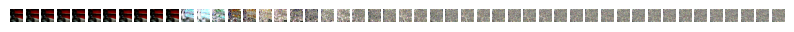

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to th

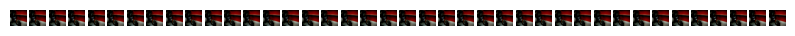

{'obs': tensor([[[-0.7333, -0.3490, -0.2784,  ..., -0.1686, -0.1686, -0.1843],
         [-0.8039, -0.6000, -0.3804,  ..., -0.1529, -0.1451, -0.1529],
         [-0.8275, -0.8745, -0.7412,  ..., -0.1137, -0.1059, -0.1137],
         ...,
         [-0.7804, -0.5059, -0.7490,  ...,  0.2706,  0.2549,  0.2392],
         [-0.4745, -0.4275, -0.7176,  ...,  0.2627,  0.2392,  0.2235],
         [-0.2706, -0.4196, -0.6941,  ...,  0.2627,  0.2392,  0.2157]],

        [[-0.7725, -0.3804, -0.3020,  ..., -0.7098, -0.7020, -0.7020],
         [-0.8431, -0.6235, -0.3882,  ..., -0.6784, -0.6706, -0.6706],
         [-0.8745, -0.8980, -0.7412,  ..., -0.6392, -0.6471, -0.6471],
         ...,
         [-0.7882, -0.4980, -0.7804,  ...,  0.2706,  0.2627,  0.2471],
         [-0.4745, -0.4196, -0.7569,  ...,  0.2549,  0.2471,  0.2314],
         [-0.2706, -0.4275, -0.7333,  ...,  0.2392,  0.2392,  0.2235]],

        [[-0.8510, -0.4510, -0.3569,  ..., -0.9137, -0.9059, -0.9059],
         [-0.9137, -0.6863, -0.4353, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to 

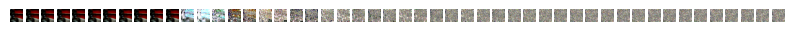

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the 

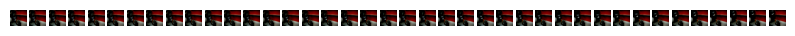

{'obs': tensor([[[-0.7804, -0.7882, -0.7804,  ..., -0.1529, -0.1608, -0.1765],
         [-0.8039, -0.8039, -0.7961,  ..., -0.1294, -0.1373, -0.1451],
         [-0.8196, -0.8118, -0.7961,  ..., -0.0980, -0.0980, -0.1059],
         ...,
         [-0.7255, -0.5294, -0.7961,  ...,  0.2549,  0.2392,  0.2235],
         [-0.4039, -0.4667, -0.8039,  ...,  0.2392,  0.2235,  0.2078],
         [-0.2627, -0.4588, -0.8039,  ...,  0.2392,  0.2235,  0.2000]],

        [[-0.8510, -0.8431, -0.8353,  ..., -0.6941, -0.7020, -0.7020],
         [-0.8588, -0.8588, -0.8510,  ..., -0.6784, -0.6784, -0.6784],
         [-0.8667, -0.8667, -0.8510,  ..., -0.6549, -0.6471, -0.6471],
         ...,
         [-0.7255, -0.5373, -0.8353,  ...,  0.2549,  0.2392,  0.2392],
         [-0.4039, -0.4824, -0.8353,  ...,  0.2392,  0.2314,  0.2235],
         [-0.2549, -0.4745, -0.8275,  ...,  0.2314,  0.2235,  0.2078]],

        [[-0.8902, -0.8902, -0.8824,  ..., -0.9216, -0.9294, -0.9294],
         [-0.9059, -0.9059, -0.8980, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to t

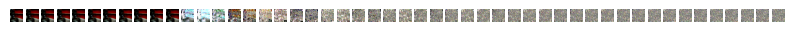

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to th

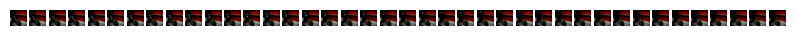

{'obs': tensor([[[ 0.0510,  0.0039, -0.0196,  ..., -0.1765, -0.1843, -0.1843],
         [ 0.0588,  0.0118, -0.0196,  ..., -0.1294, -0.1373, -0.1451],
         [ 0.0510,  0.0196, -0.0039,  ..., -0.0902, -0.0980, -0.1059],
         ...,
         [-0.8510, -0.5765, -0.6706,  ...,  0.2471,  0.2314,  0.2314],
         [-0.6157, -0.4353, -0.6706,  ...,  0.2392,  0.2235,  0.2157],
         [-0.3176, -0.4118, -0.6863,  ...,  0.2314,  0.2235,  0.2078]],

        [[ 0.0667, -0.0118, -0.1137,  ..., -0.7098, -0.7020, -0.7020],
         [ 0.0667, -0.0039, -0.1059,  ..., -0.6784, -0.6784, -0.6784],
         [ 0.0588, -0.0039, -0.0902,  ..., -0.6471, -0.6471, -0.6471],
         ...,
         [-0.8431, -0.5765, -0.7098,  ...,  0.2549,  0.2392,  0.2392],
         [-0.6078, -0.4353, -0.7098,  ...,  0.2392,  0.2235,  0.2157],
         [-0.3098, -0.4039, -0.7255,  ...,  0.2235,  0.2157,  0.2000]],

        [[ 0.0275, -0.0588, -0.1686,  ..., -0.9216, -0.9137, -0.9059],
         [ 0.0353, -0.0510, -0.1608, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].
Clipping input data to the 

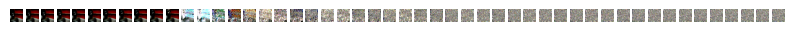

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to

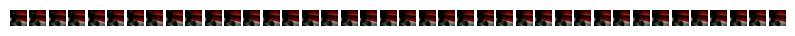

{'obs': tensor([[[ 0.6627,  0.5765,  0.2471,  ..., -0.1608, -0.1843, -0.1922],
         [ 0.5843,  0.4510, -0.3569,  ..., -0.1294, -0.1451, -0.1529],
         [ 0.5373, -0.1451, -0.7882,  ..., -0.0980, -0.1059, -0.1137],
         ...,
         [-0.8588, -0.5922, -0.6863,  ...,  0.2549,  0.2392,  0.2314],
         [-0.6235, -0.4431, -0.6863,  ...,  0.2392,  0.2314,  0.2157],
         [-0.3255, -0.4118, -0.6863,  ...,  0.2314,  0.2314,  0.2157]],

        [[ 0.8118,  0.7020,  0.3569,  ..., -0.7020, -0.7020, -0.7098],
         [ 0.7333,  0.5843, -0.2549,  ..., -0.6706, -0.6706, -0.6706],
         [ 0.6784, -0.0039, -0.7255,  ..., -0.6471, -0.6392, -0.6392],
         ...,
         [-0.8431, -0.5843, -0.7098,  ...,  0.2549,  0.2392,  0.2314],
         [-0.6157, -0.4353, -0.7098,  ...,  0.2471,  0.2314,  0.2157],
         [-0.3176, -0.4118, -0.7176,  ...,  0.2471,  0.2314,  0.2078]],

        [[ 0.8588,  0.7490,  0.3569,  ..., -0.9059, -0.9137, -0.9059],
         [ 0.7647,  0.6000, -0.2706, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the 

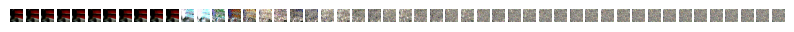

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to th

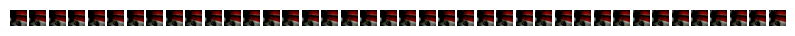

{'obs': tensor([[[-0.8667, -0.9294, -0.6235,  ..., -0.1608, -0.1686, -0.1843],
         [-0.9216, -0.8667, -0.2314,  ..., -0.1373, -0.1451, -0.1529],
         [-0.9373, -0.6078,  0.1843,  ..., -0.0980, -0.1059, -0.1137],
         ...,
         [-0.8510, -0.5843, -0.6392,  ...,  0.2549,  0.2392,  0.2314],
         [-0.6706, -0.4196, -0.6392,  ...,  0.2471,  0.2314,  0.2235],
         [-0.3490, -0.3804, -0.6549,  ...,  0.2392,  0.2314,  0.2157]],

        [[-0.8353, -0.9294, -0.6235,  ..., -0.7020, -0.6941, -0.7020],
         [-0.9059, -0.8588, -0.2314,  ..., -0.6784, -0.6706, -0.6706],
         [-0.9294, -0.6000,  0.1922,  ..., -0.6471, -0.6392, -0.6392],
         ...,
         [-0.8510, -0.5843, -0.6706,  ...,  0.2627,  0.2471,  0.2392],
         [-0.6549, -0.4118, -0.6784,  ...,  0.2471,  0.2314,  0.2235],
         [-0.3333, -0.3804, -0.6941,  ...,  0.2314,  0.2235,  0.2078]],

        [[-0.8667, -0.9294, -0.6157,  ..., -0.9294, -0.9137, -0.8902],
         [-0.9294, -0.8667, -0.2314, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to 

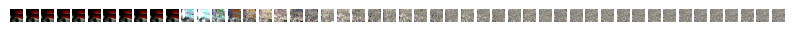

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to 

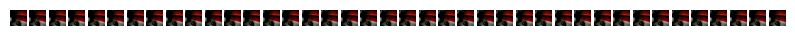

{'obs': tensor([[[-0.7882, -0.7882, -0.7882,  ..., -0.1686, -0.1765, -0.1843],
         [-0.7961, -0.8039, -0.7961,  ..., -0.1294, -0.1373, -0.1451],
         [-0.8196, -0.8196, -0.8039,  ..., -0.0902, -0.0980, -0.1059],
         ...,
         [-0.8431, -0.5843, -0.7490,  ...,  0.2627,  0.2471,  0.2235],
         [-0.6157, -0.4275, -0.7647,  ...,  0.2471,  0.2392,  0.2235],
         [-0.3176, -0.3882, -0.7804,  ...,  0.2471,  0.2235,  0.2235]],

        [[-0.8353, -0.8510, -0.8510,  ..., -0.7020, -0.7020, -0.7020],
         [-0.8431, -0.8510, -0.8431,  ..., -0.6784, -0.6784, -0.6784],
         [-0.8431, -0.8510, -0.8510,  ..., -0.6471, -0.6471, -0.6549],
         ...,
         [-0.8353, -0.5765, -0.7882,  ...,  0.2627,  0.2392,  0.2314],
         [-0.6157, -0.4275, -0.8039,  ...,  0.2471,  0.2235,  0.2157],
         [-0.3098, -0.3961, -0.8196,  ...,  0.2392,  0.2235,  0.2078]],

        [[-0.8824, -0.8902, -0.8980,  ..., -0.9059, -0.9137, -0.9137],
         [-0.8902, -0.8980, -0.8980, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to

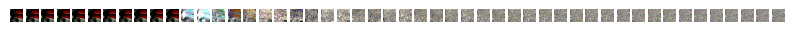

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data t

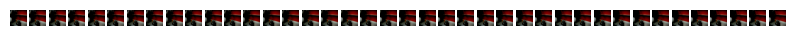

{'obs': tensor([[[-0.7961, -0.7961, -0.7804,  ..., -0.1765, -0.1765, -0.1922],
         [-0.8118, -0.8039, -0.7882,  ..., -0.1294, -0.1373, -0.1451],
         [-0.8118, -0.8118, -0.7961,  ..., -0.0902, -0.0980, -0.1059],
         ...,
         [-0.8118, -0.5608, -0.8039,  ...,  0.2627,  0.2471,  0.2314],
         [-0.5294, -0.4431, -0.8039,  ...,  0.2471,  0.2314,  0.2157],
         [-0.2784, -0.4039, -0.8196,  ...,  0.2314,  0.2235,  0.2078]],

        [[-0.8667, -0.8667, -0.8510,  ..., -0.7098, -0.7020, -0.7098],
         [-0.8667, -0.8667, -0.8510,  ..., -0.6784, -0.6784, -0.6784],
         [-0.8667, -0.8667, -0.8588,  ..., -0.6471, -0.6471, -0.6471],
         ...,
         [-0.8118, -0.5529, -0.8275,  ...,  0.2549,  0.2471,  0.2392],
         [-0.5373, -0.4431, -0.8353,  ...,  0.2471,  0.2392,  0.2235],
         [-0.2863, -0.4196, -0.8431,  ...,  0.2392,  0.2392,  0.2157]],

        [[-0.9216, -0.9216, -0.9059,  ..., -0.9373, -0.9294, -0.9216],
         [-0.9216, -0.9137, -0.9059, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to 

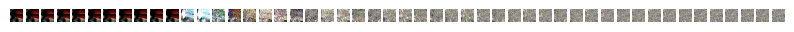

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the

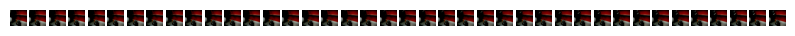

{'obs': tensor([[[ 0.4667,  0.2549, -0.2706,  ...,  0.0902,  0.0824,  0.0667],
         [ 0.4510,  0.4353,  0.1922,  ...,  0.0980,  0.0902,  0.0745],
         [ 0.5059,  0.4510,  0.4745,  ...,  0.0980,  0.0902,  0.0745],
         ...,
         [-0.5765, -0.6000, -0.5451,  ..., -0.4667, -0.3176, -0.1059],
         [-0.5843, -0.5686, -0.5373,  ..., -0.5529, -0.7176, -0.3020],
         [-0.5686, -0.5608, -0.5529,  ..., -0.3804, -0.8118, -0.7961]],

        [[ 0.5373,  0.3176, -0.2314,  ...,  0.1137,  0.1059,  0.0980],
         [ 0.5294,  0.4902,  0.2078,  ...,  0.1216,  0.1216,  0.1137],
         [ 0.5529,  0.5137,  0.5059,  ...,  0.1373,  0.1294,  0.1137],
         ...,
         [-0.6863, -0.7255, -0.6627,  ..., -0.4039, -0.2392,  0.0902],
         [-0.6863, -0.6863, -0.6392,  ..., -0.4510, -0.6471, -0.1373],
         [-0.6784, -0.6549, -0.6471,  ..., -0.2078, -0.7020, -0.6863]],

        [[ 0.7255,  0.4980, -0.1765,  ...,  0.0588,  0.0510,  0.0510],
         [ 0.5843,  0.6078,  0.3412, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the 

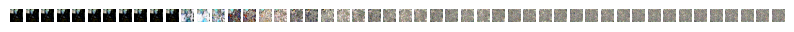

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imsho

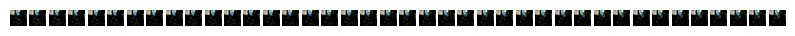

{'obs': tensor([[[ 0.4745,  0.2784, -0.2549,  ...,  0.0196,  0.0667,  0.0353],
         [ 0.4588,  0.4275,  0.2078,  ...,  0.0745,  0.0745,  0.0431],
         [ 0.5137,  0.4510,  0.4667,  ...,  0.0902,  0.0745,  0.0510],
         ...,
         [-0.5608, -0.5922, -0.5451,  ..., -0.4745, -0.3333, -0.1294],
         [-0.5686, -0.5608, -0.5373,  ..., -0.5529, -0.7333, -0.3333],
         [-0.5608, -0.5608, -0.5529,  ..., -0.3804, -0.8118, -0.8039]],

        [[ 0.5529,  0.3490, -0.2314,  ...,  0.0353,  0.0902,  0.0588],
         [ 0.5294,  0.5059,  0.2157,  ...,  0.1059,  0.1059,  0.0667],
         [ 0.5529,  0.5137,  0.5059,  ...,  0.1294,  0.1137,  0.0745],
         ...,
         [-0.6863, -0.7333, -0.6549,  ..., -0.4118, -0.2471,  0.0667],
         [-0.6863, -0.6784, -0.6392,  ..., -0.4510, -0.6549, -0.1529],
         [-0.6706, -0.6471, -0.6392,  ..., -0.2078, -0.7098, -0.6863]],

        [[ 0.7333,  0.5137, -0.1765,  ..., -0.0118,  0.0353,  0.0039],
         [ 0.5765,  0.6000,  0.3333, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imsho

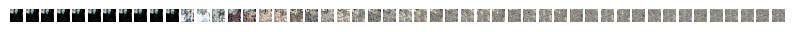

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

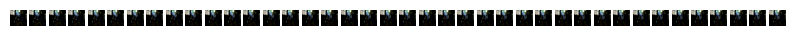

{'obs': tensor([[[ 0.4588,  0.2627, -0.2549,  ..., -0.5529, -0.5608, -0.5529],
         [ 0.4431,  0.4275,  0.2078,  ..., -0.5451, -0.5451, -0.5373],
         [ 0.4980,  0.4431,  0.4745,  ..., -0.5373, -0.5373, -0.5137],
         ...,
         [-0.5686, -0.6000, -0.5451,  ..., -0.4431, -0.2941, -0.0824],
         [-0.5765, -0.5686, -0.5373,  ..., -0.5294, -0.7176, -0.2863],
         [-0.5608, -0.5608, -0.5608,  ..., -0.3490, -0.7961, -0.7804]],

        [[ 0.5451,  0.3333, -0.2314,  ..., -0.5373, -0.5451, -0.5373],
         [ 0.5216,  0.4902,  0.2078,  ..., -0.5373, -0.5373, -0.5216],
         [ 0.5451,  0.5059,  0.5059,  ..., -0.5216, -0.5294, -0.4980],
         ...,
         [-0.6863, -0.7333, -0.6549,  ..., -0.4039, -0.2235,  0.1059],
         [-0.6941, -0.6784, -0.6314,  ..., -0.4431, -0.6471, -0.1216],
         [-0.6784, -0.6392, -0.6314,  ..., -0.1843, -0.7098, -0.6784]],

        [[ 0.7333,  0.5216, -0.1686,  ..., -0.6157, -0.6078, -0.6235],
         [ 0.5922,  0.6157,  0.3412, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

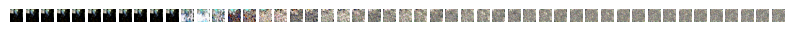

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

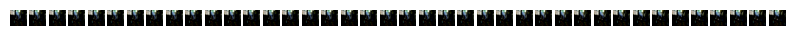

{'obs': tensor([[[ 0.4510,  0.2471, -0.2627,  ..., -0.5529, -0.5216, -0.0118],
         [ 0.4431,  0.4196,  0.1922,  ..., -0.5451, -0.4980,  0.0196],
         [ 0.4980,  0.4431,  0.4588,  ..., -0.5294, -0.4745,  0.0353],
         ...,
         [-0.5608, -0.6078, -0.5529,  ..., -0.4824, -0.3490, -0.1529],
         [-0.5686, -0.5765, -0.5529,  ..., -0.5608, -0.7255, -0.3333],
         [-0.5686, -0.5686, -0.5686,  ..., -0.3725, -0.8118, -0.8039]],

        [[ 0.5529,  0.3333, -0.2392,  ..., -0.5451, -0.5059,  0.0118],
         [ 0.5373,  0.4980,  0.2078,  ..., -0.5373, -0.4824,  0.0431],
         [ 0.5529,  0.5137,  0.5059,  ..., -0.5216, -0.4667,  0.0588],
         ...,
         [-0.7020, -0.7490, -0.6706,  ..., -0.4196, -0.2784,  0.0353],
         [-0.7020, -0.7020, -0.6471,  ..., -0.4588, -0.6627, -0.1765],
         [-0.6863, -0.6706, -0.6471,  ..., -0.2000, -0.7176, -0.6941]],

        [[ 0.7412,  0.5294, -0.1608,  ..., -0.5922, -0.5843, -0.1137],
         [ 0.6078,  0.6392,  0.3490, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

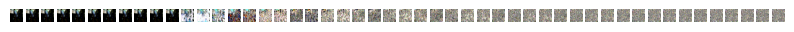

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

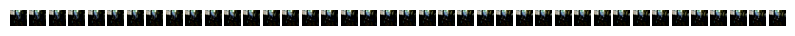

{'obs': tensor([[[-0.0980,  0.0196, -0.0510,  ..., -0.8902, -0.9137, -0.9216],
         [-0.0510,  0.0275,  0.0039,  ..., -0.9137, -0.9294, -0.9294],
         [-0.0118,  0.0431,  0.0196,  ..., -0.9294, -0.9373, -0.9373],
         ...,
         [-0.7882, -0.4902, -0.7176,  ...,  0.6784,  0.6471,  0.6235],
         [-0.4667, -0.3647, -0.7569,  ...,  0.6863,  0.6549,  0.6235],
         [-0.2392, -0.3255, -0.7882,  ...,  0.6784,  0.6627,  0.6314]],

        [[-0.0902,  0.0275, -0.0353,  ..., -0.7412, -0.7490, -0.7569],
         [-0.0431,  0.0353,  0.0196,  ..., -0.7412, -0.7490, -0.7490],
         [-0.0039,  0.0510,  0.0275,  ..., -0.7490, -0.7412, -0.7490],
         ...,
         [-0.7569, -0.4667, -0.7333,  ...,  0.6941,  0.6627,  0.6392],
         [-0.4275, -0.3255, -0.7647,  ...,  0.7020,  0.6706,  0.6392],
         [-0.1922, -0.2706, -0.7961,  ...,  0.6941,  0.6784,  0.6471]],

        [[-0.0745,  0.0431, -0.0196,  ..., -0.5059, -0.5216, -0.5294],
         [-0.0275,  0.0510,  0.0275, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

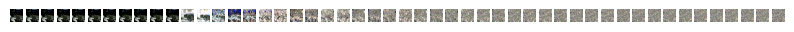

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the 

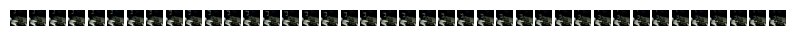

{'obs': tensor([[[-0.4745, -0.8902, -0.8588,  ..., -0.9059, -0.9137, -0.9216],
         [-0.8196, -0.9137, -0.7176,  ..., -0.9137, -0.9294, -0.9294],
         [-0.9608, -0.8588, -0.2863,  ..., -0.9373, -0.9451, -0.9451],
         ...,
         [-0.7804, -0.4980, -0.7176,  ...,  0.6706,  0.6314,  0.6000],
         [-0.4745, -0.3804, -0.7490,  ...,  0.6863,  0.6392,  0.6157],
         [-0.2471, -0.3412, -0.7882,  ...,  0.6706,  0.6627,  0.6314]],

        [[-0.4196, -0.8431, -0.8275,  ..., -0.7412, -0.7490, -0.7569],
         [-0.7725, -0.8745, -0.6941,  ..., -0.7412, -0.7490, -0.7569],
         [-0.9216, -0.8275, -0.2706,  ..., -0.7333, -0.7490, -0.7569],
         ...,
         [-0.7569, -0.4745, -0.7255,  ...,  0.7020,  0.6706,  0.6392],
         [-0.4275, -0.3412, -0.7490,  ...,  0.7098,  0.6784,  0.6471],
         [-0.2000, -0.2941, -0.7961,  ...,  0.6863,  0.6784,  0.6471]],

        [[-0.4980, -0.8745, -0.8196,  ..., -0.5137, -0.5216, -0.5294],
         [-0.8275, -0.8980, -0.6863, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

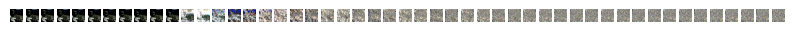

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

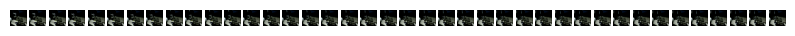

{'obs': tensor([[[-0.4902, -0.8824, -0.8588,  ..., -0.9059, -0.9216, -0.9216],
         [-0.8196, -0.9137, -0.7098,  ..., -0.9216, -0.9294, -0.9216],
         [-0.9529, -0.8588, -0.2784,  ..., -0.9373, -0.9373, -0.9294],
         ...,
         [-0.7804, -0.5059, -0.7176,  ...,  0.6706,  0.6314,  0.6000],
         [-0.4667, -0.3882, -0.7490,  ...,  0.6784,  0.6392,  0.6157],
         [-0.2471, -0.3490, -0.7882,  ...,  0.6706,  0.6549,  0.6314]],

        [[-0.4196, -0.8431, -0.8353,  ..., -0.7412, -0.7490, -0.7569],
         [-0.7647, -0.8824, -0.6941,  ..., -0.7333, -0.7412, -0.7569],
         [-0.9216, -0.8275, -0.2627,  ..., -0.7412, -0.7490, -0.7490],
         ...,
         [-0.7490, -0.4745, -0.7176,  ...,  0.7020,  0.6784,  0.6392],
         [-0.4275, -0.3412, -0.7490,  ...,  0.7098,  0.6706,  0.6471],
         [-0.2000, -0.3020, -0.7961,  ...,  0.6863,  0.6706,  0.6471]],

        [[-0.4745, -0.8667, -0.8353,  ..., -0.5216, -0.5294, -0.5451],
         [-0.8118, -0.8902, -0.6863, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

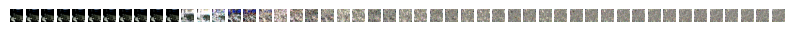

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

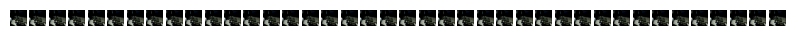

{'obs': tensor([[[ 0.0902,  0.0353, -0.0039,  ..., -0.9059, -0.9137, -0.9137],
         [ 0.0980,  0.0353,  0.0275,  ..., -0.9137, -0.9294, -0.9294],
         [ 0.1059,  0.0667,  0.0275,  ..., -0.9373, -0.9373, -0.9373],
         ...,
         [-0.7804, -0.5137, -0.7255,  ...,  0.6706,  0.6314,  0.6000],
         [-0.4431, -0.3882, -0.7647,  ...,  0.6784,  0.6392,  0.6078],
         [-0.2314, -0.3333, -0.8118,  ...,  0.6706,  0.6549,  0.6235]],

        [[ 0.0980,  0.0431,  0.0039,  ..., -0.7333, -0.7490, -0.7569],
         [ 0.1059,  0.0431,  0.0353,  ..., -0.7333, -0.7490, -0.7569],
         [ 0.1137,  0.0745,  0.0353,  ..., -0.7333, -0.7490, -0.7490],
         ...,
         [-0.7490, -0.4745, -0.7412,  ...,  0.6941,  0.6706,  0.6471],
         [-0.4118, -0.3490, -0.7725,  ...,  0.7020,  0.6706,  0.6471],
         [-0.2000, -0.3020, -0.8118,  ...,  0.6863,  0.6706,  0.6392]],

        [[ 0.1216,  0.0588,  0.0275,  ..., -0.5216, -0.5216, -0.5216],
         [ 0.1216,  0.0588,  0.0510, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

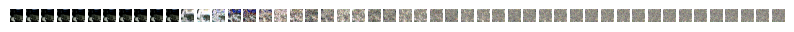

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

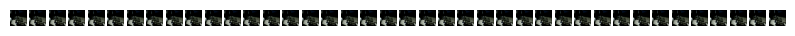

{'obs': tensor([[[ 0.2784,  0.2314,  0.2078,  ..., -0.9137, -0.9294, -0.9216],
         [ 0.2784,  0.2392,  0.2235,  ..., -0.9373, -0.9451, -0.9373],
         [ 0.2784,  0.2549,  0.2392,  ..., -0.9451, -0.9451, -0.9529],
         ...,
         [-0.6471, -0.7412, -0.7176,  ...,  0.6392,  0.6078,  0.5922],
         [-0.2627, -0.6471, -0.7804,  ...,  0.6471,  0.6235,  0.6000],
         [-0.1529, -0.5765, -0.8353,  ...,  0.6549,  0.6392,  0.6078]],

        [[ 0.2863,  0.2471,  0.2235,  ..., -0.7412, -0.7569, -0.7647],
         [ 0.2863,  0.2549,  0.2392,  ..., -0.7412, -0.7490, -0.7569],
         [ 0.2863,  0.2706,  0.2549,  ..., -0.7412, -0.7490, -0.7569],
         ...,
         [-0.6157, -0.7176, -0.7333,  ...,  0.6784,  0.6471,  0.6157],
         [-0.2314, -0.6157, -0.7882,  ...,  0.6863,  0.6471,  0.6157],
         [-0.1294, -0.5373, -0.8353,  ...,  0.6706,  0.6549,  0.6235]],

        [[ 0.3020,  0.2314,  0.2078,  ..., -0.5137, -0.5294, -0.5294],
         [ 0.3020,  0.2392,  0.2235, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

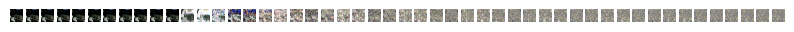

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

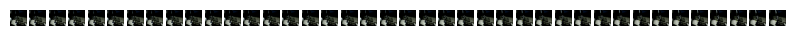

{'obs': tensor([[[-0.8039, -0.8039, -0.8196,  ..., -0.9137, -0.9294, -0.9294],
         [-0.8039, -0.8039, -0.8196,  ..., -0.9373, -0.9451, -0.9373],
         [-0.7961, -0.8039, -0.8196,  ..., -0.9529, -0.9529, -0.9529],
         ...,
         [-0.8118, -0.8902, -0.7098,  ...,  0.5765,  0.5529,  0.5137],
         [-0.4275, -0.8353, -0.7882,  ...,  0.5922,  0.5451,  0.5137],
         [-0.2706, -0.7647, -0.8667,  ...,  0.5686,  0.5451,  0.5137]],

        [[-0.7490, -0.7412, -0.7490,  ..., -0.7569, -0.7725, -0.7725],
         [-0.7412, -0.7333, -0.7412,  ..., -0.7725, -0.7804, -0.7804],
         [-0.7333, -0.7176, -0.7333,  ..., -0.7725, -0.7882, -0.7882],
         ...,
         [-0.7804, -0.8667, -0.7098,  ...,  0.6000,  0.5765,  0.5451],
         [-0.4039, -0.8039, -0.7804,  ...,  0.6157,  0.5765,  0.5529],
         [-0.2392, -0.7333, -0.8588,  ...,  0.6000,  0.5843,  0.5529]],

        [[-0.6706, -0.6627, -0.6471,  ..., -0.5529, -0.5686, -0.5765],
         [-0.6627, -0.6549, -0.6471, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

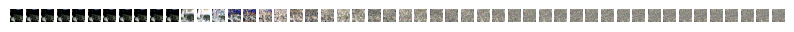

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

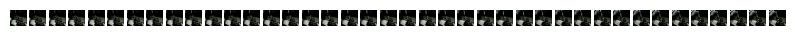

{'obs': tensor([[[ 0.8118,  0.8588,  0.8275,  ..., -0.9137, -0.9294, -0.9294],
         [ 0.8353,  0.8667,  0.8667,  ..., -0.9294, -0.9373, -0.9373],
         [ 0.8667,  0.8824,  0.7961,  ..., -0.9294, -0.9373, -0.9373],
         ...,
         [-0.7882, -0.8745, -0.7176,  ...,  0.5765,  0.5529,  0.5294],
         [-0.4118, -0.7961, -0.7882,  ...,  0.5843,  0.5529,  0.5294],
         [-0.2549, -0.7255, -0.8588,  ...,  0.5765,  0.5608,  0.5294]],

        [[ 0.8667,  0.9137,  0.8745,  ..., -0.7569, -0.7725, -0.7725],
         [ 0.8980,  0.9294,  0.9294,  ..., -0.7647, -0.7804, -0.7804],
         [ 0.9216,  0.9451,  0.8588,  ..., -0.7647, -0.7804, -0.7804],
         ...,
         [-0.7569, -0.8431, -0.7176,  ...,  0.5922,  0.5686,  0.5451],
         [-0.3725, -0.7725, -0.7882,  ...,  0.6000,  0.5686,  0.5451],
         [-0.2235, -0.7020, -0.8588,  ...,  0.5922,  0.5765,  0.5451]],

        [[ 0.9216,  0.9529,  0.8824,  ..., -0.5608, -0.5765, -0.5765],
         [ 0.9216,  0.9529,  0.9373, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data 

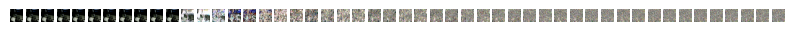

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the val

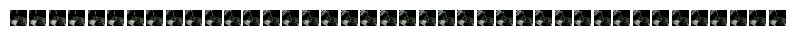

{'obs': tensor([[[-0.5137, -0.8196, -0.8275,  ..., -0.9137, -0.9294, -0.9373],
         [-0.5216, -0.8196, -0.8196,  ..., -0.9294, -0.9451, -0.9529],
         [-0.5294, -0.8118, -0.8118,  ..., -0.9451, -0.9529, -0.9529],
         ...,
         [-0.7333, -0.6549, -0.7961,  ...,  0.5608,  0.5294,  0.4980],
         [-0.3647, -0.5529, -0.8353,  ...,  0.5765,  0.5451,  0.5137],
         [-0.2314, -0.5137, -0.8510,  ...,  0.5686,  0.5529,  0.5294]],

        [[-0.4510, -0.7490, -0.7569,  ..., -0.7569, -0.7725, -0.7804],
         [-0.4588, -0.7412, -0.7412,  ..., -0.7647, -0.7804, -0.7882],
         [-0.4667, -0.7333, -0.7333,  ..., -0.7725, -0.7804, -0.7804],
         ...,
         [-0.6941, -0.6235, -0.7961,  ...,  0.6000,  0.5686,  0.5451],
         [-0.3176, -0.5137, -0.8196,  ...,  0.6000,  0.5765,  0.5529],
         [-0.1843, -0.4667, -0.8353,  ...,  0.5843,  0.5686,  0.5451]],

        [[-0.4353, -0.6863, -0.6706,  ..., -0.5608, -0.5765, -0.5843],
         [-0.4431, -0.6784, -0.6627, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with 

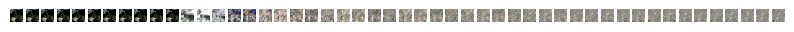

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

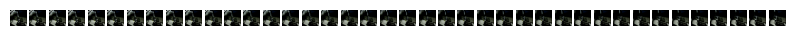

{'obs': tensor([[[-0.8588, -0.8824, -0.9059,  ..., -0.2157, -0.2078, -0.2078],
         [-0.8667, -0.8745, -0.8980,  ..., -0.2078, -0.1922, -0.2000],
         [-0.8667, -0.8824, -0.9059,  ..., -0.1765, -0.1765, -0.1922],
         ...,
         [ 0.1765,  0.1922,  0.2157,  ..., -0.5216, -0.4510, -0.7333],
         [ 0.1765,  0.1922,  0.2157,  ..., -0.5451, -0.4667, -0.4902],
         [ 0.1843,  0.2000,  0.2235,  ..., -0.5608, -0.4980, -0.4431]],

        [[-0.8510, -0.8667, -0.8980,  ..., -0.2000, -0.1922, -0.1922],
         [-0.8510, -0.8667, -0.8824,  ..., -0.1765, -0.1686, -0.1686],
         [-0.8510, -0.8588, -0.8824,  ..., -0.1373, -0.1373, -0.1529],
         ...,
         [ 0.2000,  0.2157,  0.2392,  ..., -0.5765, -0.4510, -0.7333],
         [ 0.1922,  0.2157,  0.2392,  ..., -0.6392, -0.4902, -0.4824],
         [ 0.1922,  0.2078,  0.2314,  ..., -0.6863, -0.5608, -0.4431]],

        [[-0.8431, -0.8431, -0.8824,  ..., -0.2392, -0.2314, -0.2235],
         [-0.8588, -0.8588, -0.8745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the 

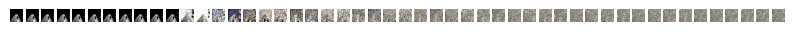

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the 

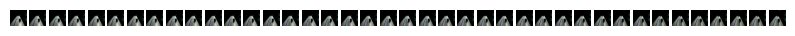

{'obs': tensor([[[-0.8667, -0.8824, -0.9059,  ..., -0.2078, -0.1922, -0.2000],
         [-0.8667, -0.8745, -0.8980,  ..., -0.1765, -0.1686, -0.1843],
         [-0.8667, -0.8824, -0.8980,  ..., -0.1294, -0.1608, -0.1765],
         ...,
         [ 0.1765,  0.1922,  0.2157,  ..., -0.4980, -0.4353, -0.7255],
         [ 0.1765,  0.1922,  0.2157,  ..., -0.5294, -0.4431, -0.4745],
         [ 0.1765,  0.1843,  0.2157,  ..., -0.5529, -0.4902, -0.4196]],

        [[-0.8510, -0.8667, -0.8902,  ..., -0.1765, -0.1765, -0.1843],
         [-0.8588, -0.8667, -0.8824,  ..., -0.1451, -0.1451, -0.1608],
         [-0.8588, -0.8667, -0.8824,  ..., -0.1059, -0.1216, -0.1373],
         ...,
         [ 0.2000,  0.2157,  0.2392,  ..., -0.5765, -0.4431, -0.7176],
         [ 0.2000,  0.2157,  0.2392,  ..., -0.6471, -0.4902, -0.4824],
         [ 0.1922,  0.2157,  0.2314,  ..., -0.6863, -0.5608, -0.4353]],

        [[-0.8431, -0.8667, -0.8745,  ..., -0.2235, -0.2157, -0.2235],
         [-0.8353, -0.8510, -0.8902, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the

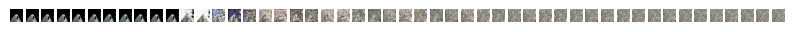

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the

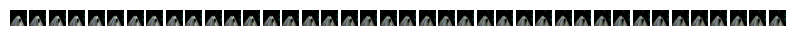

{'obs': tensor([[[-0.8745, -0.8824, -0.8980,  ..., -0.2157, -0.2078, -0.2078],
         [-0.8745, -0.8745, -0.8980,  ..., -0.1843, -0.1765, -0.1843],
         [-0.8588, -0.8745, -0.9059,  ..., -0.1451, -0.1608, -0.1843],
         ...,
         [ 0.1765,  0.1843,  0.2157,  ..., -0.4980, -0.4275, -0.7176],
         [ 0.1765,  0.1843,  0.2157,  ..., -0.5294, -0.4431, -0.4745],
         [ 0.1765,  0.1843,  0.2157,  ..., -0.5451, -0.4824, -0.4196]],

        [[-0.8588, -0.8745, -0.8980,  ..., -0.2000, -0.1922, -0.1922],
         [-0.8667, -0.8667, -0.8824,  ..., -0.1686, -0.1608, -0.1686],
         [-0.8510, -0.8667, -0.8824,  ..., -0.1137, -0.1294, -0.1451],
         ...,
         [ 0.1922,  0.2078,  0.2392,  ..., -0.5686, -0.4353, -0.7098],
         [ 0.1922,  0.2078,  0.2314,  ..., -0.6392, -0.4824, -0.4667],
         [ 0.1922,  0.2157,  0.2314,  ..., -0.6784, -0.5608, -0.4275]],

        [[-0.8588, -0.8431, -0.8667,  ..., -0.2392, -0.2235, -0.2157],
         [-0.8431, -0.8510, -0.8824, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the

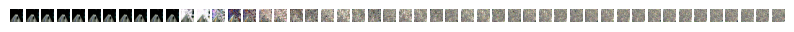

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to t

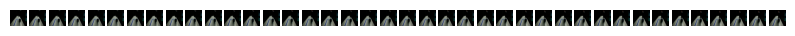

{'obs': tensor([[[-0.8667, -0.8824, -0.9059,  ..., -0.2235, -0.2078, -0.2235],
         [-0.8667, -0.8745, -0.8980,  ..., -0.1922, -0.1765, -0.2000],
         [-0.8588, -0.8824, -0.9059,  ..., -0.1529, -0.1608, -0.1922],
         ...,
         [ 0.1686,  0.1843,  0.2157,  ..., -0.5059, -0.4275, -0.7098],
         [ 0.1765,  0.1922,  0.2235,  ..., -0.5373, -0.4353, -0.4588],
         [ 0.1843,  0.1922,  0.2235,  ..., -0.5608, -0.4745, -0.4118]],

        [[-0.8431, -0.8667, -0.8902,  ..., -0.1922, -0.1843, -0.1843],
         [-0.8588, -0.8667, -0.8902,  ..., -0.1608, -0.1529, -0.1608],
         [-0.8510, -0.8667, -0.8824,  ..., -0.1216, -0.1294, -0.1529],
         ...,
         [ 0.2000,  0.2078,  0.2392,  ..., -0.5686, -0.4353, -0.7020],
         [ 0.2000,  0.2078,  0.2392,  ..., -0.6392, -0.4902, -0.4667],
         [ 0.1922,  0.2000,  0.2314,  ..., -0.6863, -0.5608, -0.4275]],

        [[-0.8353, -0.8431, -0.8824,  ..., -0.2392, -0.2235, -0.2157],
         [-0.8510, -0.8510, -0.8824, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to t

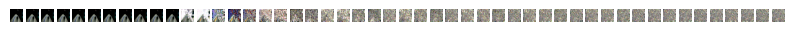

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to

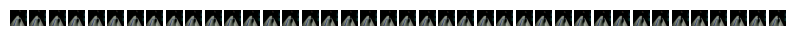

{'obs': tensor([[[-0.8824, -0.8980, -0.8980,  ..., -0.2000, -0.2157, -0.2157],
         [-0.8824, -0.8824, -0.8902,  ..., -0.1686, -0.1686, -0.1765],
         [-0.8745, -0.8745, -0.8980,  ..., -0.1216, -0.1451, -0.1608],
         ...,
         [ 0.1608,  0.1922,  0.2157,  ..., -0.4980, -0.4275, -0.7098],
         [ 0.1686,  0.1922,  0.2157,  ..., -0.5294, -0.4353, -0.4588],
         [ 0.1608,  0.1922,  0.2157,  ..., -0.5529, -0.4824, -0.4039]],

        [[-0.8510, -0.8667, -0.8824,  ..., -0.1843, -0.1843, -0.1686],
         [-0.8588, -0.8667, -0.8824,  ..., -0.1529, -0.1373, -0.1373],
         [-0.8431, -0.8667, -0.8902,  ..., -0.0980, -0.1059, -0.1216],
         ...,
         [ 0.1922,  0.2157,  0.2392,  ..., -0.5765, -0.4275, -0.6941],
         [ 0.1843,  0.2078,  0.2392,  ..., -0.6392, -0.4824, -0.4667],
         [ 0.1922,  0.2157,  0.2392,  ..., -0.6784, -0.5608, -0.4196]],

        [[-0.8353, -0.8431, -0.8824,  ..., -0.2235, -0.2314, -0.2157],
         [-0.8510, -0.8510, -0.8745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to th

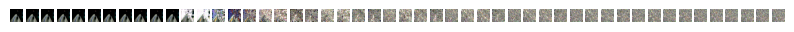

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to th

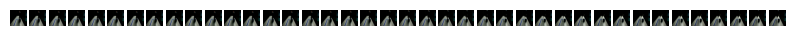

{'obs': tensor([[[-0.8824, -0.8824, -0.9137,  ..., -0.1922, -0.2078, -0.2078],
         [-0.8745, -0.8745, -0.8980,  ..., -0.1608, -0.1686, -0.1765],
         [-0.8667, -0.8745, -0.9059,  ..., -0.1216, -0.1451, -0.1608],
         ...,
         [ 0.1529,  0.1922,  0.2157,  ..., -0.4902, -0.4118, -0.7176],
         [ 0.1529,  0.1843,  0.2157,  ..., -0.5216, -0.4196, -0.4588],
         [ 0.1451,  0.1843,  0.2235,  ..., -0.5529, -0.4745, -0.4039]],

        [[-0.8588, -0.8745, -0.8902,  ..., -0.1608, -0.1765, -0.1765],
         [-0.8510, -0.8667, -0.8902,  ..., -0.1373, -0.1451, -0.1529],
         [-0.8431, -0.8667, -0.8902,  ..., -0.1059, -0.1216, -0.1451],
         ...,
         [ 0.1922,  0.2157,  0.2392,  ..., -0.5686, -0.4275, -0.6941],
         [ 0.1922,  0.2157,  0.2392,  ..., -0.6392, -0.4824, -0.4588],
         [ 0.1922,  0.2157,  0.2471,  ..., -0.6784, -0.5608, -0.4196]],

        [[-0.8588, -0.8588, -0.8824,  ..., -0.1686, -0.1843, -0.1843],
         [-0.8667, -0.8588, -0.8745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the 

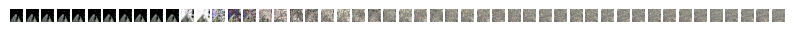

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to th

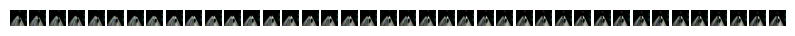

{'obs': tensor([[[-0.8902, -0.8902, -0.8980,  ..., -0.1765, -0.2078, -0.2235],
         [-0.8824, -0.8745, -0.8902,  ..., -0.1529, -0.1686, -0.1922],
         [-0.8667, -0.8745, -0.8980,  ..., -0.1294, -0.1529, -0.1686],
         ...,
         [ 0.1686,  0.1843,  0.2157,  ..., -0.4902, -0.4196, -0.7098],
         [ 0.1765,  0.1922,  0.2157,  ..., -0.5216, -0.4353, -0.4588],
         [ 0.1843,  0.2000,  0.2235,  ..., -0.5451, -0.4745, -0.4039]],

        [[-0.8510, -0.8667, -0.8902,  ..., -0.1686, -0.1765, -0.1765],
         [-0.8588, -0.8667, -0.8824,  ..., -0.1373, -0.1451, -0.1451],
         [-0.8510, -0.8667, -0.8824,  ..., -0.0980, -0.1137, -0.1294],
         ...,
         [ 0.1922,  0.2078,  0.2392,  ..., -0.5686, -0.4275, -0.7020],
         [ 0.1922,  0.2078,  0.2392,  ..., -0.6392, -0.4745, -0.4588],
         [ 0.1922,  0.2078,  0.2314,  ..., -0.6863, -0.5608, -0.4196]],

        [[-0.8353, -0.8667, -0.8745,  ..., -0.1922, -0.2157, -0.2314],
         [-0.8588, -0.8510, -0.8745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to 

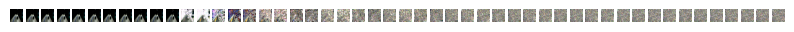

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to

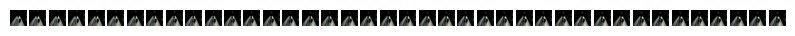

{'obs': tensor([[[-0.8745, -0.8824, -0.9059,  ..., -0.2157, -0.2078, -0.2000],
         [-0.8902, -0.8824, -0.8902,  ..., -0.2000, -0.1843, -0.1765],
         [-0.8667, -0.8745, -0.8980,  ..., -0.1451, -0.1451, -0.1686],
         ...,
         [ 0.1451,  0.1843,  0.2157,  ..., -0.4980, -0.4275, -0.7176],
         [ 0.1451,  0.1765,  0.2157,  ..., -0.5294, -0.4431, -0.4745],
         [ 0.1451,  0.1843,  0.2157,  ..., -0.5529, -0.4902, -0.4275]],

        [[-0.8588, -0.8667, -0.8824,  ..., -0.1922, -0.1922, -0.1843],
         [-0.8510, -0.8588, -0.8824,  ..., -0.1608, -0.1529, -0.1529],
         [-0.8510, -0.8667, -0.8824,  ..., -0.1059, -0.1059, -0.1294],
         ...,
         [ 0.1922,  0.2157,  0.2392,  ..., -0.5686, -0.4353, -0.7176],
         [ 0.1922,  0.2157,  0.2392,  ..., -0.6392, -0.4824, -0.4745],
         [ 0.1922,  0.2078,  0.2314,  ..., -0.6863, -0.5608, -0.4353]],

        [[-0.8510, -0.8588, -0.8824,  ..., -0.2235, -0.2157, -0.2078],
         [-0.8588, -0.8667, -0.8745, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to 

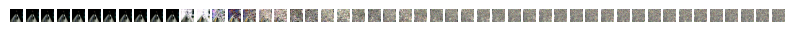

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to t

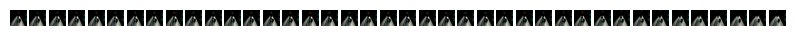

{'obs': tensor([[[-0.9686, -0.9765, -0.9529,  ..., -0.8118, -0.8275, -0.8510],
         [-0.9294, -0.9686, -0.9529,  ..., -0.7882, -0.7961, -0.8431],
         [-0.9059, -0.9373, -0.9529,  ..., -0.7882, -0.8118, -0.8431],
         ...,
         [-0.9765, -0.9686, -0.9529,  ..., -0.9059, -0.9059, -0.8902],
         [-0.9843, -0.9686, -0.9529,  ..., -0.8667, -0.9216, -0.9451],
         [-0.9843, -0.9686, -0.9529,  ..., -0.8353, -0.8667, -0.9294]],

        [[-0.9451, -0.9529, -0.9294,  ..., -0.8039, -0.8196, -0.8431],
         [-0.9059, -0.9451, -0.9294,  ..., -0.7804, -0.7882, -0.8353],
         [-0.8824, -0.9137, -0.9294,  ..., -0.7804, -0.8039, -0.8353],
         ...,
         [-0.9608, -0.9608, -0.9529,  ..., -0.8902, -0.8980, -0.8824],
         [-0.9608, -0.9608, -0.9529,  ..., -0.8510, -0.8980, -0.9294],
         [-0.9608, -0.9529, -0.9451,  ..., -0.8118, -0.8353, -0.8980]],

        [[-0.9922, -1.0000, -0.9843,  ..., -0.8431, -0.8588, -0.8824],
         [-0.9608, -0.9922, -0.9843, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

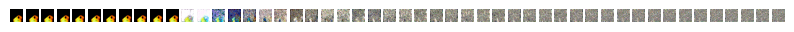

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range fo

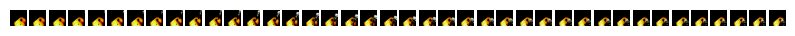

{'obs': tensor([[[-0.9608, -0.9608, -0.9294,  ..., -0.7882, -0.8118, -0.8275],
         [-0.9216, -0.9608, -0.9373,  ..., -0.7725, -0.7804, -0.8196],
         [-0.8824, -0.9216, -0.9373,  ..., -0.7725, -0.7961, -0.8196],
         ...,
         [-0.9765, -0.9686, -0.9373,  ..., -0.6235, -0.6784, -0.5216],
         [-0.9843, -0.9686, -0.9451,  ..., -0.6078, -0.6706, -0.5922],
         [-0.9765, -0.9608, -0.9451,  ..., -0.6392, -0.6706, -0.6078]],

        [[-0.9529, -0.9529, -0.9216,  ..., -0.7804, -0.8039, -0.8196],
         [-0.9137, -0.9529, -0.9294,  ..., -0.7647, -0.7725, -0.8118],
         [-0.8745, -0.9137, -0.9294,  ..., -0.7647, -0.7882, -0.8118],
         ...,
         [-0.9686, -0.9608, -0.9451,  ..., -0.6000, -0.7098, -0.6078],
         [-0.9686, -0.9608, -0.9529,  ..., -0.5922, -0.6784, -0.6000],
         [-0.9608, -0.9529, -0.9451,  ..., -0.6157, -0.6549, -0.5843]],

        [[-0.9922, -1.0000, -0.9922,  ..., -0.8196, -0.8510, -0.8745],
         [-0.9529, -1.0000, -0.9922, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

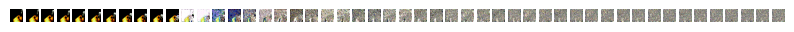

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

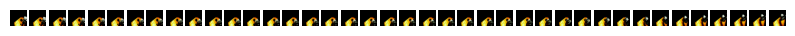

{'obs': tensor([[[-0.1922, -0.1608, -0.1686,  ...,  0.1765,  0.1608,  0.0980],
         [-0.2000, -0.1686, -0.1608,  ...,  0.1686,  0.1137,  0.0980],
         [-0.2157, -0.1922, -0.1765,  ...,  0.0745,  0.0667,  0.1216],
         ...,
         [-0.9216, -0.9765, -0.9451,  ..., -0.3255, -0.3569, -0.3961],
         [-0.9216, -0.9608, -0.8980,  ..., -0.3255, -0.3647, -0.3882],
         [-0.9216, -0.9294, -0.9529,  ..., -0.3255, -0.3725, -0.3961]],

        [[-0.4353, -0.4196, -0.4118,  ...,  0.2235,  0.2078,  0.1529],
         [-0.4431, -0.4275, -0.4196,  ...,  0.2078,  0.1686,  0.1451],
         [-0.4431, -0.4431, -0.4353,  ...,  0.1294,  0.1216,  0.1686],
         ...,
         [-0.9059, -0.9608, -0.9216,  ..., -0.7255, -0.7333, -0.7569],
         [-0.9059, -0.9451, -0.8824,  ..., -0.7255, -0.7412, -0.7412],
         [-0.9059, -0.9137, -0.9373,  ..., -0.7176, -0.7490, -0.7490]],

        [[-0.9216, -0.8980, -0.8902,  ...,  0.1529,  0.1529,  0.1137],
         [-0.8980, -0.8902, -0.8824, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

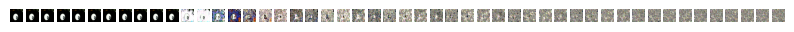

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

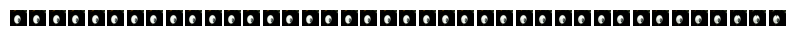

{'obs': tensor([[[-0.1843, -0.1608, -0.1451,  ...,  0.1765,  0.1608,  0.0980],
         [-0.2000, -0.1765, -0.1608,  ...,  0.1529,  0.1059,  0.0980],
         [-0.2078, -0.1922, -0.1765,  ...,  0.0667,  0.0588,  0.1137],
         ...,
         [-0.9216, -0.9765, -0.9451,  ..., -0.3255, -0.3569, -0.3961],
         [-0.9216, -0.9608, -0.9216,  ..., -0.3255, -0.3569, -0.3804],
         [-0.9373, -0.9373, -0.9686,  ..., -0.3176, -0.3647, -0.3882]],

        [[-0.4431, -0.4275, -0.4118,  ...,  0.2314,  0.2157,  0.1608],
         [-0.4431, -0.4275, -0.4118,  ...,  0.2157,  0.1608,  0.1529],
         [-0.4510, -0.4431, -0.4275,  ...,  0.1294,  0.1137,  0.1686],
         ...,
         [-0.9059, -0.9608, -0.9294,  ..., -0.7176, -0.7333, -0.7647],
         [-0.9059, -0.9451, -0.9059,  ..., -0.7255, -0.7333, -0.7412],
         [-0.9216, -0.9216, -0.9529,  ..., -0.7176, -0.7412, -0.7412]],

        [[-0.9216, -0.9216, -0.9059,  ...,  0.1529,  0.1529,  0.0902],
         [-0.9137, -0.9137, -0.8980, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

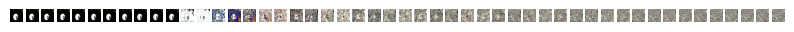

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

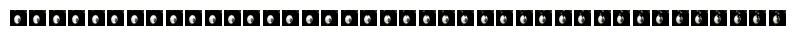

{'obs': tensor([[[-0.7333, -0.9765, -0.8118,  ...,  0.1765,  0.1529,  0.0980],
         [-0.3804, -0.8353, -0.9529,  ...,  0.1608,  0.1137,  0.1059],
         [-0.2157, -0.4745, -0.9137,  ...,  0.0745,  0.0667,  0.1137],
         ...,
         [-0.9216, -0.9765, -0.9451,  ..., -0.3255, -0.3569, -0.3961],
         [-0.9294, -0.9608, -0.9216,  ..., -0.3176, -0.3647, -0.3882],
         [-0.9373, -0.9373, -0.9686,  ..., -0.3176, -0.3725, -0.3882]],

        [[-0.8039, -0.9843, -0.8667,  ...,  0.2314,  0.2078,  0.1529],
         [-0.5059, -0.8745, -0.9686,  ...,  0.2157,  0.1686,  0.1608],
         [-0.4118, -0.5922, -0.9373,  ...,  0.1373,  0.1216,  0.1686],
         ...,
         [-0.9059, -0.9608, -0.9294,  ..., -0.7255, -0.7176, -0.7569],
         [-0.9137, -0.9529, -0.9059,  ..., -0.7333, -0.7333, -0.7412],
         [-0.9216, -0.9216, -0.9451,  ..., -0.7333, -0.7412, -0.7490]],

        [[-0.9451, -1.0000, -0.9451,  ...,  0.1529,  0.1608,  0.0980],
         [-0.8353, -0.9529, -1.0000, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

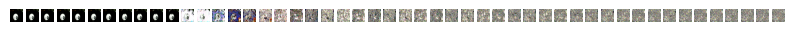

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

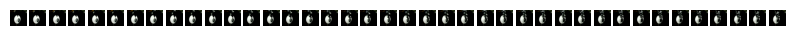

{'obs': tensor([[[-0.8118, -0.9059, -0.6000,  ...,  0.1765,  0.1608,  0.1059],
         [-0.4667, -0.8902, -0.7882,  ...,  0.1608,  0.1059,  0.0980],
         [-0.2471, -0.6627, -0.9294,  ...,  0.0824,  0.0667,  0.1137],
         ...,
         [-0.9216, -0.9765, -0.9451,  ..., -0.3255, -0.3490, -0.3961],
         [-0.9294, -0.9686, -0.9294,  ..., -0.3255, -0.3490, -0.3725],
         [-0.9373, -0.9451, -0.9765,  ..., -0.3333, -0.3647, -0.3804]],

        [[-0.8510, -0.9137, -0.6078,  ...,  0.2314,  0.2157,  0.1608],
         [-0.5843, -0.9137, -0.8039,  ...,  0.2157,  0.1608,  0.1529],
         [-0.4275, -0.7333, -0.9451,  ...,  0.1294,  0.1137,  0.1686],
         ...,
         [-0.9059, -0.9608, -0.9294,  ..., -0.7176, -0.7333, -0.7569],
         [-0.9137, -0.9451, -0.8980,  ..., -0.7255, -0.7333, -0.7412],
         [-0.9216, -0.9137, -0.9451,  ..., -0.7255, -0.7412, -0.7490]],

        [[-0.9373, -0.9451, -0.6549,  ...,  0.1451,  0.1608,  0.1059],
         [-0.8275, -0.9686, -0.8588, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

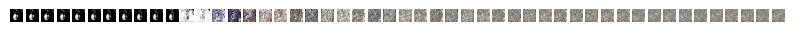

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imsho

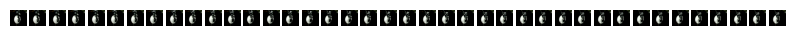

{'obs': tensor([[[-0.1765, -0.1686, -0.1529,  ...,  0.1843,  0.1686,  0.1059],
         [-0.2000, -0.1765, -0.1686,  ...,  0.1686,  0.1137,  0.1059],
         [-0.2000, -0.1843, -0.1765,  ...,  0.0824,  0.0667,  0.1137],
         ...,
         [-0.9216, -0.9765, -0.9529,  ..., -0.3176, -0.3490, -0.3882],
         [-0.9216, -0.9608, -0.9216,  ..., -0.3176, -0.3490, -0.3804],
         [-0.9294, -0.9373, -0.9686,  ..., -0.3255, -0.3647, -0.3804]],

        [[-0.4431, -0.4275, -0.4196,  ...,  0.2235,  0.2078,  0.1608],
         [-0.4431, -0.4275, -0.4196,  ...,  0.2157,  0.1686,  0.1608],
         [-0.4431, -0.4353, -0.4275,  ...,  0.1216,  0.1137,  0.1765],
         ...,
         [-0.9059, -0.9608, -0.9373,  ..., -0.7176, -0.7255, -0.7647],
         [-0.9059, -0.9451, -0.9059,  ..., -0.7176, -0.7255, -0.7490],
         [-0.9137, -0.9216, -0.9529,  ..., -0.7176, -0.7412, -0.7412]],

        [[-0.9059, -0.9137, -0.9137,  ...,  0.1451,  0.1529,  0.1059],
         [-0.8980, -0.9059, -0.9059, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

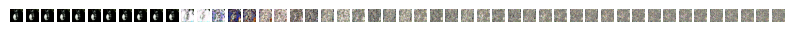

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

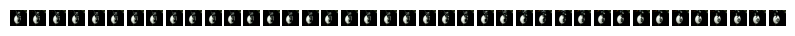

{'obs': tensor([[[-0.7333, -0.8510, -0.9686,  ...,  0.1765,  0.1529,  0.1059],
         [-0.4980, -0.6000, -0.7255,  ...,  0.1608,  0.1059,  0.1059],
         [-0.3176, -0.4745, -0.5294,  ...,  0.0745,  0.0745,  0.1294],
         ...,
         [-0.9373, -0.9765, -0.9608,  ..., -0.3333, -0.3490, -0.3882],
         [-0.9373, -0.9608, -0.9216,  ..., -0.3333, -0.3569, -0.3725],
         [-0.9373, -0.9373, -0.9608,  ..., -0.3255, -0.3647, -0.3804]],

        [[-0.7098, -0.8353, -0.9529,  ...,  0.2235,  0.1922,  0.1451],
         [-0.5216, -0.5843, -0.7098,  ...,  0.2157,  0.1529,  0.1529],
         [-0.4275, -0.4902, -0.5059,  ...,  0.1373,  0.1216,  0.1765],
         ...,
         [-0.9059, -0.9608, -0.9294,  ..., -0.7255, -0.7333, -0.7569],
         [-0.9137, -0.9451, -0.8980,  ..., -0.7176, -0.7333, -0.7412],
         [-0.9216, -0.9216, -0.9451,  ..., -0.7176, -0.7412, -0.7412]],

        [[-0.7804, -0.8745, -0.9765,  ...,  0.1373,  0.1373,  0.0980],
         [-0.6627, -0.6314, -0.7490, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

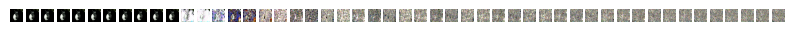

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB dat

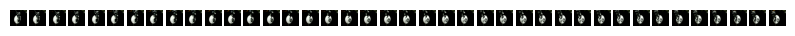

{'obs': tensor([[[ 0.3412,  0.4510,  0.5529,  ...,  0.1843,  0.1608,  0.1137],
         [ 0.0431,  0.0431,  0.1059,  ...,  0.1686,  0.1216,  0.1059],
         [-0.5765, -0.6706, -0.5608,  ...,  0.0745,  0.0667,  0.1216],
         ...,
         [-0.9373, -0.9686, -0.9608,  ..., -0.3255, -0.3490, -0.3882],
         [-0.9373, -0.9608, -0.9216,  ..., -0.3255, -0.3490, -0.3725],
         [-0.9373, -0.9294, -0.9529,  ..., -0.3255, -0.3647, -0.3804]],

        [[ 0.3647,  0.4902,  0.6000,  ...,  0.2314,  0.2078,  0.1529],
         [ 0.0745,  0.0824,  0.1451,  ...,  0.2157,  0.1608,  0.1451],
         [-0.5294, -0.6314, -0.5216,  ...,  0.1294,  0.1216,  0.1686],
         ...,
         [-0.8980, -0.9608, -0.9294,  ..., -0.7176, -0.7333, -0.7569],
         [-0.9059, -0.9451, -0.8980,  ..., -0.7176, -0.7333, -0.7412],
         [-0.9216, -0.9137, -0.9373,  ..., -0.7176, -0.7412, -0.7412]],

        [[ 0.3490,  0.4667,  0.5608,  ...,  0.1373,  0.1451,  0.0980],
         [ 0.0353,  0.0510,  0.1059, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

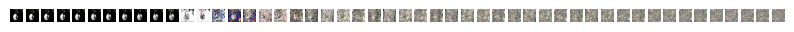

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

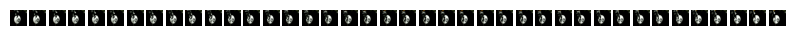

{'obs': tensor([[[-0.8510, -0.8275, -0.8431,  ..., -0.7569, -0.7490, -0.7255],
         [-0.8588, -0.8353, -0.8431,  ..., -0.4745, -0.4588, -0.4510],
         [-0.8745, -0.8510, -0.8431,  ..., -0.4353, -0.4588, -0.4588],
         ...,
         [-0.5843, -0.6000, -0.6314,  ..., -0.2549, -0.3176, -0.5608],
         [-0.6157, -0.6549, -0.5843,  ..., -0.2471, -0.3255, -0.5922],
         [-0.6627, -0.6078, -0.5765,  ..., -0.3490, -0.3647, -0.6314]],

        [[-0.8275, -0.8039, -0.8196,  ..., -0.7804, -0.7490, -0.7176],
         [-0.8275, -0.8039, -0.8118,  ..., -0.4902, -0.4510, -0.4431],
         [-0.8353, -0.8118, -0.8039,  ..., -0.4275, -0.4510, -0.4431],
         ...,
         [-0.5765, -0.5922, -0.6235,  ..., -0.0510, -0.1373, -0.4353],
         [-0.6078, -0.6471, -0.5765,  ..., -0.0431, -0.1608, -0.4745],
         [-0.6549, -0.6000, -0.5686,  ..., -0.1451, -0.2000, -0.5529]],

        [[-0.8745, -0.8588, -0.8667,  ..., -0.8275, -0.7882, -0.7569],
         [-0.8745, -0.8510, -0.8588, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

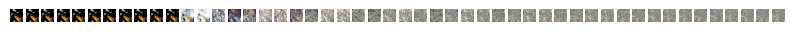

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

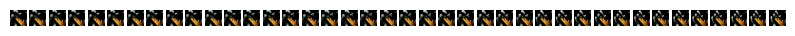

{'obs': tensor([[[-0.8745, -0.8431, -0.8353,  ..., -0.7490, -0.7333, -0.6941],
         [-0.8745, -0.8431, -0.8275,  ..., -0.4588, -0.4431, -0.4431],
         [-0.8745, -0.8510, -0.8353,  ..., -0.4510, -0.4667, -0.4588],
         ...,
         [-0.5765, -0.6078, -0.6314,  ..., -0.2471, -0.3020, -0.5451],
         [-0.6157, -0.6627, -0.5843,  ..., -0.2471, -0.3176, -0.5765],
         [-0.6706, -0.6078, -0.5765,  ..., -0.3490, -0.3647, -0.6235]],

        [[-0.8353, -0.8118, -0.8275,  ..., -0.7569, -0.7412, -0.7020],
         [-0.8353, -0.8118, -0.8196,  ..., -0.4588, -0.4431, -0.4431],
         [-0.8353, -0.8118, -0.8118,  ..., -0.4431, -0.4588, -0.4510],
         ...,
         [-0.5686, -0.6000, -0.6235,  ..., -0.0431, -0.1451, -0.4275],
         [-0.6078, -0.6549, -0.5765,  ..., -0.0431, -0.1529, -0.4667],
         [-0.6627, -0.6000, -0.5686,  ..., -0.1608, -0.1922, -0.5373]],

        [[-0.8667, -0.8431, -0.8431,  ..., -0.7961, -0.7804, -0.7412],
         [-0.8667, -0.8431, -0.8353, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

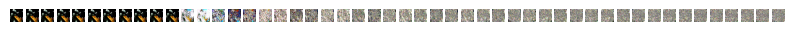

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

KeyboardInterrupt: 

In [19]:
test_dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=50,
    img_size=(64, 64),
)
for idx in range(0, len(test_dataset), 20):
    try:
        
        batch = test_dataset[idx]
        frames = batch["context_obs"]
        actions = batch["context_acts"]
        print(batch)

        # frames, actions, _, _ = test_dataset[150]
        frames_cond = frames[:K]
        # frames_cond = frames

        pred_frames = frames_cond.clone().to(device)
        actions = actions.to(device)
        
        # print(pred_frames.shape, actions.shape)
        for i in range(K, 50):
            pred_diff = models[-1].sample(
                pred_frames[-K:].unsqueeze(0),
                actions[i-K:i].unsqueeze(0),                           # Corresponding K actions
                img_wh=(frames.shape[-2], frames.shape[-1]),
                guidance_scale=5.0,
                N=1,
            )
            #     actions[i-K:i].unsqueeze(0),                 # corresponding K actions
            #     img_wh=(frames.shape[-2], frames.shape[-1]),
            #     guidance_scale=5.0,
            #     N=1,
            # )
            # print(pred_diff.shape)
            # print(pred_frames[-1].shape)
            pred = pred_frames[-1] + pred_diff
            pred = pred.clamp(0, 1)
            # print(pred.shape)
            # print(pred_frames.shape)
            pred_frames = torch.cat([pred_frames, pred], dim=0)  # append prediction

    finally:
        pass
        # test_dataset.close()

    displayImageRow(pred_frames.cpu().permute(0, 2, 3, 1), figsize=(10,10))
    displayImageRow(frames[K:].permute(0, 2, 3, 1), figsize=(10,10))
    save_frames_as_gif(pred_frames, filename+f"predicted_{idx}.gif")
    save_frames_as_gif(frames, filename+f"ground_truth_{idx}.gif")


In [29]:
frames.shape

torch.Size([10, 3, 64, 64])

In [30]:
pred_frames.shape

torch.Size([5, 3, 64, 64])